In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime, timedelta
from tqdm import tqdm

import sys
sys.path.append("..")

from matplotlib.dates import DateFormatter
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose


#### Helper functions

In [2]:
from functions import (
    missingValues,
    df_security_code,
    print_shape, 
    date_range
)

In [3]:
sns.color_palette("tab10")
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
# plots 
sns.set_context('talk', font_scale=1)
plt.style.use(['ggplot'])
#plt.rcParams['image.cmap'] = "orangered"
plt.rcParams.update({'font.sans-serif':'Helvetica'})

# Data


## stock_list.csv

In [4]:
stock_list = pd.read_csv('../data/stock_list.csv', parse_dates=['EffectiveDate', 'TradeDate'])

In [5]:
stock_list.head(2)

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,2021-12-30,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,2021-12-30,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False


number of securities

In [6]:
stock_list.SecuritiesCode.nunique()

4417

distribution of the stocks into 33 Sectors

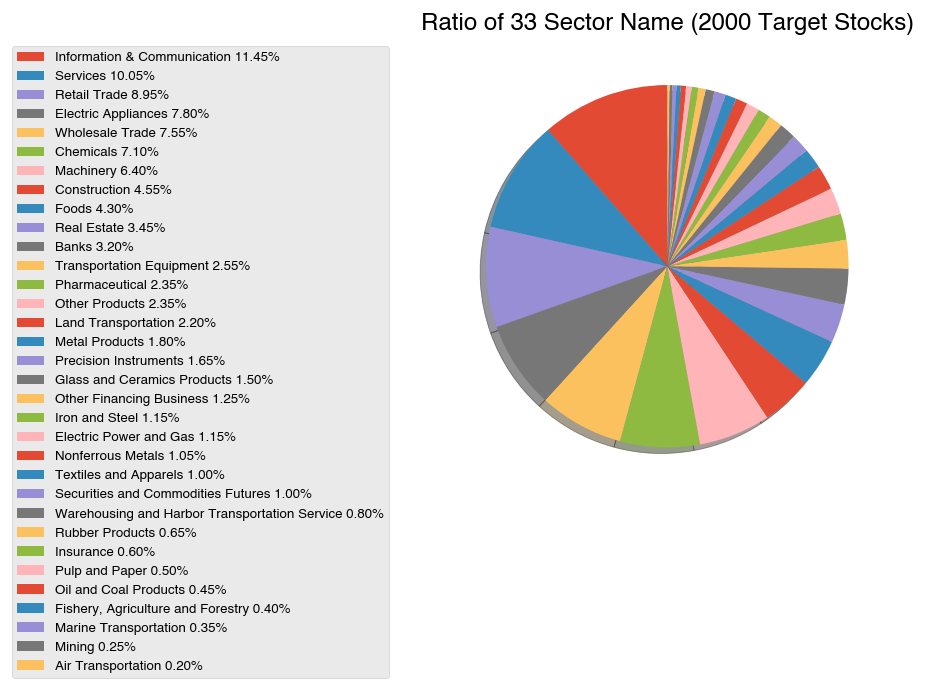

In [7]:
target_stock_list = stock_list[stock_list['Universe0']]
sec_33_val_cnt = target_stock_list['33SectorName'].value_counts()
pct = sec_33_val_cnt / sec_33_val_cnt.sum() * 100
labels = [f"{sec} {ratio:.2f}%" for sec, ratio in zip(sec_33_val_cnt.index, pct)]

fig, ax = plt.subplots(figsize=(10, 5))
patches, texts = ax.pie(sec_33_val_cnt.values, 
                        #colors=sns.color_palette("pastel"), 
                        shadow=True, 
                        startangle=90)
patches, labels, dummy = zip(*sorted(zip(patches, labels, sec_33_val_cnt.values),
                                     key=lambda x: x[2],
                                     reverse=True))
ax.legend(patches, labels, bbox_to_anchor=(-0.1, 1.), fontsize=8)
ax.set_title("Ratio of 33 Sector Name (2000 Target Stocks)")
plt.show()

distribution of the stocks into 17 Sectors

In [9]:
sec_17_val_cnt = target_stock_list['17SectorName'].value_counts()
pct = sec_17_val_cnt / sec_17_val_cnt.sum() * 100

sec_17_val_cnt


industries = pd.DataFrame(sec_17_val_cnt)

industries['pct'] = pct
industries

,17SectorName,pct
"IT & SERVICES, OTHERS",477,23.85
ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,189,9.45
RETAIL TRADE,179,8.95
RAW MATERIALS & CHEMICALS,172,8.60
CONSTRUCTION & MATERIALS,157,7.85
COMMERCIAL & WHOLESALE TRADE,151,7.55
MACHINERY,128,6.40
FOODS,94,4.70
TRANSPORTATION & LOGISTICS,71,3.55
REAL ESTATE,69,3.45


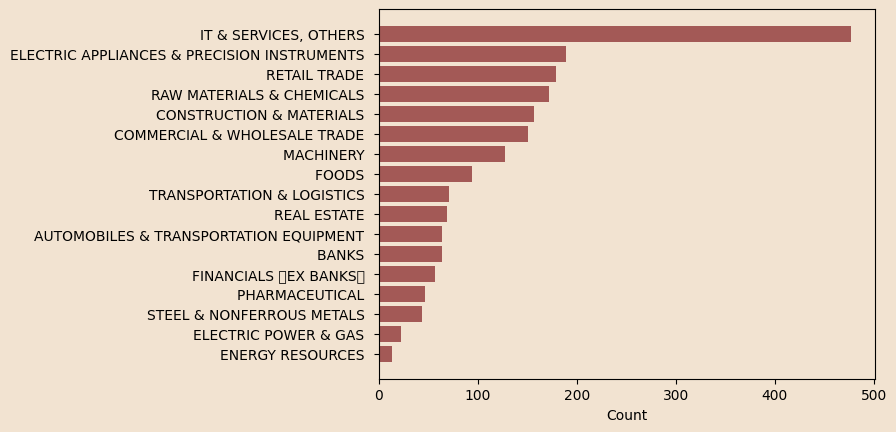

In [10]:
sec_17_val_cnt = target_stock_list['17SectorName'].value_counts()
pct = sec_17_val_cnt / sec_17_val_cnt.sum() * 100

sec_17_val_cnt

industries = pd.DataFrame(sec_17_val_cnt)
industries['pct'] = pct
industries.sort_values('pct', ascending=False)
y_pos = np.arange(len(industries))
# #3E4953
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, industries['17SectorName'].sort_values(ascending=True),align='center', color='#A35956')
ax.set_yticks(y_pos, labels=reversed(industries.index))
plt.xlabel('Count')

ax.set_facecolor('#F2E3D1')
fig.patch.set_facecolor('#F2E3D1')
plt.rcParams["font.family"] = "Hind Siliguri"

top 5 stocks accoring the market capitalization

In [12]:
stock_list.sort_values('MarketCapitalization', ascending=False).head(5)

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
137,1557,2021-12-30,SPDR S&P500 ETF Trust,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,54920.0,9.503321e+08,5.219224e+13,False
3065,7203,2021-12-30,TOYOTA MOTOR CORPORATION,First Section (Domestic),Prime Market,3700,Transportation Equipment,6,AUTOMOBILES & TRANSPORTATION EQUIPMENT,1,TOPIX Core30,20211230.0,2105.5,1.631499e+10,3.435121e+13,True
2804,6758,2021-12-30,SONY GROUP CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,14475.0,1.261082e+09,1.825416e+13,True
2867,6861,2021-12-30,KEYENCE CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,72280.0,2.432077e+08,1.757905e+13,True
2,1306,2021-12-30,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False


In [13]:
prices = pd.read_csv('../data/train_files/stock_prices.csv', parse_dates=[1])
sec_codes = prices.SecuritiesCode.unique()
del prices

date observation for the stock list

In [14]:
date = stock_list.EffectiveDate
date_desc = date.describe(datetime_is_numeric=True)
date_min = date_desc.loc['min']
date_max = date_desc.loc['max']
print('Data from {:%Y-%m-%d} to {:%Y-%m-%d}'
            .format(date_min, date_max))
print('Data observations {} '.format(
                    date.nunique()))

Data from 2000-01-01 to 2022-02-25
Data observations 10 


filter the stock list with the codes used in stock prices and save it

In [15]:
stock_list = stock_list[stock_list['SecuritiesCode'].isin(sec_codes)]
stock_list.to_csv('../data/stock_list_2000.csv')

In [18]:
del stock_list

## Financials

In [150]:
financial = pd.read_csv('../data/train_files/financials.csv', parse_dates=['Date'])

In [20]:
financial.head(2)

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0


remove the revision for furhter processing

In [23]:
# drop 
financial = financial.query('TypeOfDocument != ["ForecastRevision", "ForecastRevision_REIT"]')

In [24]:
financial.head(2)

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0
3,2.017010e+13,20170105_2659,2017-01-05,2659.0,2017-01-05,15:00:00,1.483596e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,285.05,NaN,False,True,False,False,False,31981654.0,18257,31963405.0
7,2.017011e+13,20170105_3344,2017-01-05,3344.0,2017-01-05,15:00:00,1.483596e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,47.7,NaN,False,True,False,False,False,5579184.0,1372,5578257.0
9,2.017010e+13,20170105_7453,2017-01-05,7453.0,2017-01-05,15:00:00,1.483596e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,913.28,NaN,False,True,True,False,False,28078000.0,1702372,26527712.0


select columns used to feature engineering

In [153]:
liste =[ 'Date', 'SecuritiesCode', 'Profit', 'NetSales', 'OperatingProfit', 'BookValuePerShare',
        'ForecastDividendPerShareFiscalYearEnd',
        'ForecastDividendPerShareAnnual', 'ForecastNetSales',
        'ForecastOperatingProfit', 'ForecastOrdinaryProfit', 'ForecastProfit',
        'ForecastEarningsPerShare']

financial = financial[liste]
financial.head(2)

,Date,SecuritiesCode,Profit,NetSales,OperatingProfit,BookValuePerShare,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare
0,2017-01-04,2753.0,1494000000,22761000000,2147000000,2671.42,50.0,100.0,31800000000,3255000000,3300000000,2190000000,319.76
1,2017-01-04,3353.0,629000000,22128000000,820000000,NaN,36.0,72.0,30200000000,1350000000,1300000000,930000000,485.36


In [27]:
#financial.SecuritiesCode.nunique()
# Selecting only matching Codes from financial data
prices = pd.read_csv('../data/train_files/stock_prices.csv', parse_dates=[1])
sec_codes = [x for x in prices.SecuritiesCode.unique() if x in financial.SecuritiesCode.unique()]


In [28]:
print_shape(financial)

 Shape:
 ----------------------------------------
 Observations:   75.6K
 Features:       13
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['Date', 'SecuritiesCode', 'Profit', 'NetSales', 'OperatingProfit',
       'BookValuePerShare', 'ForecastDividendPerShareFiscalYearEnd',
       'ForecastDividendPerShareAnnual', 'ForecastNetSales',
       'ForecastOperatingProfit', 'ForecastOrdinaryProfit', 'ForecastProfit',
       'ForecastEarningsPerShare'],
      dtype='object')
----------------------------------------


,N_missing,Percentage
BookValuePerShare,39868.0,52.71
ForecastOperatingProfit,8362.0,11.05
ForecastOrdinaryProfit,7164.0,9.47
ForecastNetSales,7045.0,9.31
ForecastEarningsPerShare,6956.0,9.20
ForecastProfit,6166.0,8.15
OperatingProfit,2195.0,2.90
ForecastDividendPerShareFiscalYearEnd,1584.0,2.09
ForecastDividendPerShareAnnual,1583.0,2.09
Profit,261.0,0.35


In [ ]:
del financial

## Options

In [157]:
options = pd.read_csv('../data/train_files/options.csv', parse_dates=[1])

In [39]:
options.head(2)

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0


In [159]:
print_shape(options, missing=False)

 Shape:
 ----------------------------------------
 Observations:   3.57M
 Features:       31
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['DateCode', 'Date', 'OptionsCode', 'WholeDayOpen', 'WholeDayHigh',
       'WholeDayLow', 'WholeDayClose', 'NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose', 'TradingVolume',
       'OpenInterest', 'TradingValue', 'ContractMonth', 'StrikePrice',
       'WholeDayVolume', 'Putcall', 'LastTradingDay', 'SpecialQuotationDay',
       'SettlementPrice', 'TheoreticalPrice', 'BaseVolatility',
       'ImpliedVolatility', 'InterestRate', 'DividendRate', 'Dividend'],
      dtype='object')
----------------------------------------


- codes : more than securites code

In [41]:
options.OptionsCode.nunique()

14732

In [43]:
del options

## Submission

In [161]:
submission = pd.read_csv('../data/example_test_files/sample_submission.csv', date_parser=[0])
submission.shape

(112000, 3)

In [162]:
print_shape(submission, False)

 Shape:
 ----------------------------------------
 Observations:   112K
 Features:       3
 Feature Date:    object
----------------------------------------
Index(['Date', 'SecuritiesCode', 'Rank'], dtype='object')
----------------------------------------


In [45]:
submission.nunique()

Date                56
SecuritiesCode    2000
Rank              2000
dtype: int64

In [46]:
submission.head(2)

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4


Target: calculate the rank for each security code for the next 56 working days

In [47]:
del submission

## Stock prices

In [163]:
prices = pd.read_csv('../data/train_files/stock_prices.csv', parse_dates=[1])
print_shape(prices)

 Shape:
 ----------------------------------------
 Observations:   2.33M
 Features:       12
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')
----------------------------------------


,N_missing,Percentage
ExpectedDividend,2313666.0,99.19
Open,7608.0,0.33
High,7608.0,0.33
Low,7608.0,0.33
Close,7608.0,0.33
Target,238.0,0.01
RowId,0.0,0.00
Date,0.0,0.00
SecuritiesCode,0.0,0.00
Volume,0.0,0.00


In [49]:
prices.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324


### - Date

In [50]:
date = prices.Date
date_desc = date.describe(datetime_is_numeric=True)
date_min = date_desc.loc['min']
date_max = date_desc.loc['max']
print('Data from {:%Y-%m-%d} to {:%Y-%m-%d}'
        .format(date_min, date_max))
print('Data observations {} '.format(
                 date.nunique()))

Data from 2017-01-04 to 2021-12-03
Data observations 1202 


- amount of trades each day

In [ ]:
count = pd.DataFrame(prices.SecuritiesCode.value_counts())

In [179]:
count = pd.DataFrame(prices.Date.value_counts())
count.columns = ['Securities']
#count.reset_index('Date', inplace=True)

count.head(2)

,Securities
2021-12-03,2000
2021-04-08,2000


Text(0.5, 0, 'Date')

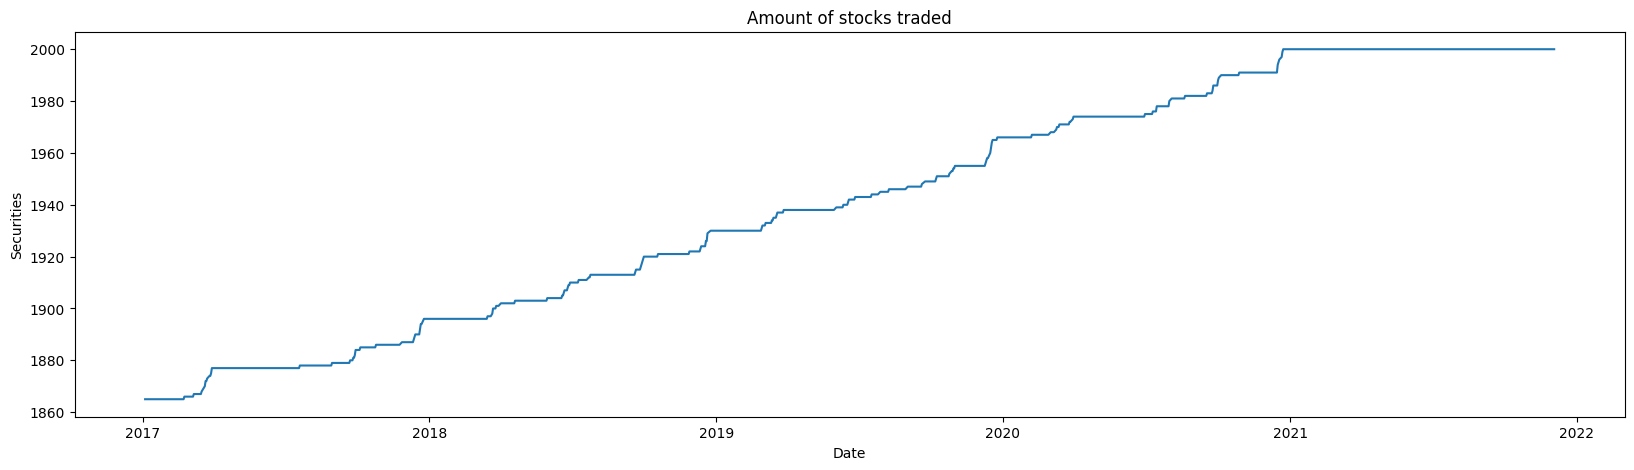

In [181]:

plt.figure(figsize = (20,5))
sns.lineplot(data = count, x= count.index, y ='Securities')
plt.title('Amount of stocks traded')
plt.xlabel('Date')

are stocks added during the time? 
compare the stocks in 1 feb 2017 with the stocks in 1 Feb 2121 

In [55]:
# stock for each days
feb2017 = prices[prices['Date']=='2017-2-1']
feb2021 = prices[prices['Date']=='2021-2-1']

print('SecuritiesCode for Feb 2017 : {} \nSecuritiesCode for Feb 2021 : {}'. format(
                                    feb2017.SecuritiesCode.nunique(), feb2021.SecuritiesCode.nunique()
))

SecuritiesCode for Feb 2017 : 1865 
SecuritiesCode for Feb 2021 : 2000


In [182]:
# new Securites Code in 2021
codes_2017 = feb2017.SecuritiesCode.to_list()
new_codes = feb2021[~feb2021['SecuritiesCode'].isin(codes_2017)]
old_codes = feb2021[~feb2021['SecuritiesCode'].isin(new_codes.SecuritiesCode.to_list())]
print(f'new codes since 2017: {new_codes.SecuritiesCode.count()}')
#print(old_codes.SecuritiesCode.count())

new codes since 2017: 135


In [57]:
def plot_stock(df, Code, feature='Target'):
    df = df.query('SecuritiesCode==@Code')
    #plt.figure(figsize=(20,5))
    sns.lineplot(data=df, y=feature, x='Date', label=code)

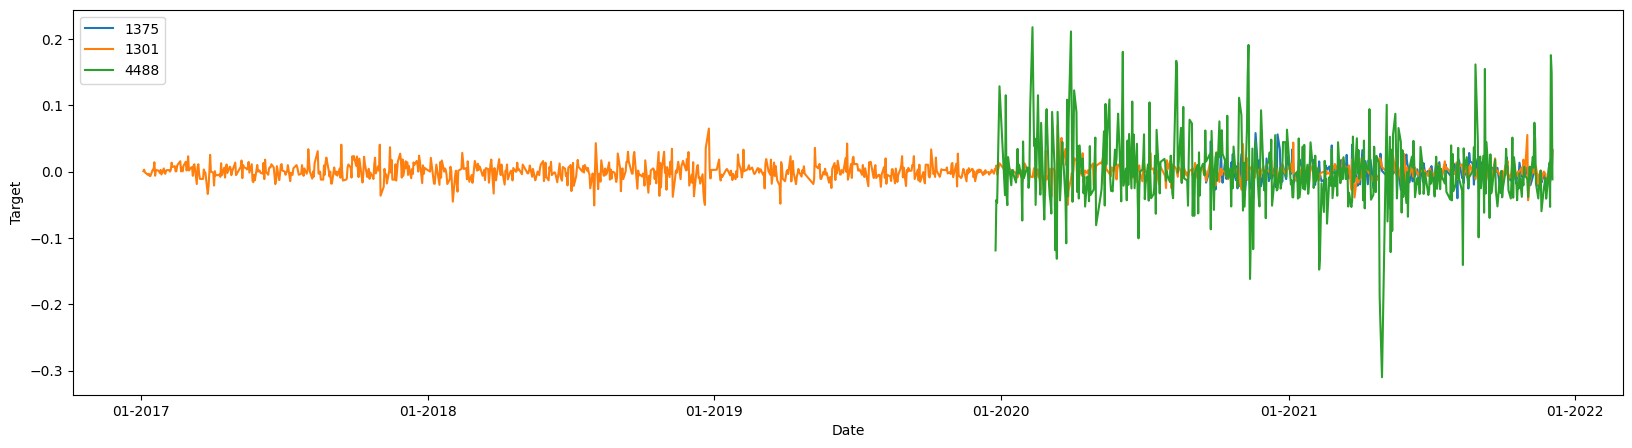

In [58]:
fig, ax = plt.subplots(figsize=(20,5))
for code in [1375, 1301, 4488]:
    plot_stock(prices, code)

    ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))

there are 135 Securities codes not listed in 2017. 
may be they were launch later. 

### nan values

In [59]:
a = prices[(prices['Date']=='2021-12-03')]
a.count()

RowId               2000
Date                2000
SecuritiesCode      2000
Open                1995
High                1995
Low                 1995
Close               1995
Volume              2000
AdjustmentFactor    2000
ExpectedDividend       0
SupervisionFlag     2000
Target              2000
dtype: int64

In [60]:
a.query('Open != Open')

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2330563,20211203_1787,2021-12-03,1787,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.030351
2330786,20211203_2761,2021-12-03,2761,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
2331453,20211203_5918,2021-12-03,5918,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.015625
2332336,20211203_9083,2021-12-03,9083,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.009615
2332462,20211203_9733,2021-12-03,9733,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000


a day before

In [61]:
b = prices[(prices['Date']=='2021-12-02')]
b.query('Open != Open')

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2328632,20211202_1981,2021-12-02,1981,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
2328786,20211202_2761,2021-12-02,2761,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.015714
2328823,20211202_2923,2021-12-02,2923,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.004274
2330462,20211202_9733,2021-12-02,9733,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000


and before

In [62]:
c = prices[(prices['Date']=='2021-12-01')]
c.query('Open != Open')

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2326786,20211201_2761,2021-12-01,2761,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
2326804,20211201_2814,2021-12-01,2814,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.010481
2327247,20211201_4628,2021-12-01,4628,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.011984
2328419,20211201_9539,2021-12-01,9539,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.005917
2328462,20211201_9733,2021-12-01,9733,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000


In [63]:
d = prices[(prices['Date']=='2021-12-01')]
c.query('Open != Open')

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2326786,20211201_2761,2021-12-01,2761,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
2326804,20211201_2814,2021-12-01,2814,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.010481
2327247,20211201_4628,2021-12-01,4628,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.011984
2328419,20211201_9539,2021-12-01,9539,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.005917
2328462,20211201_9733,2021-12-01,9733,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000


<AxesSubplot:xlabel='Date', ylabel='Open'>

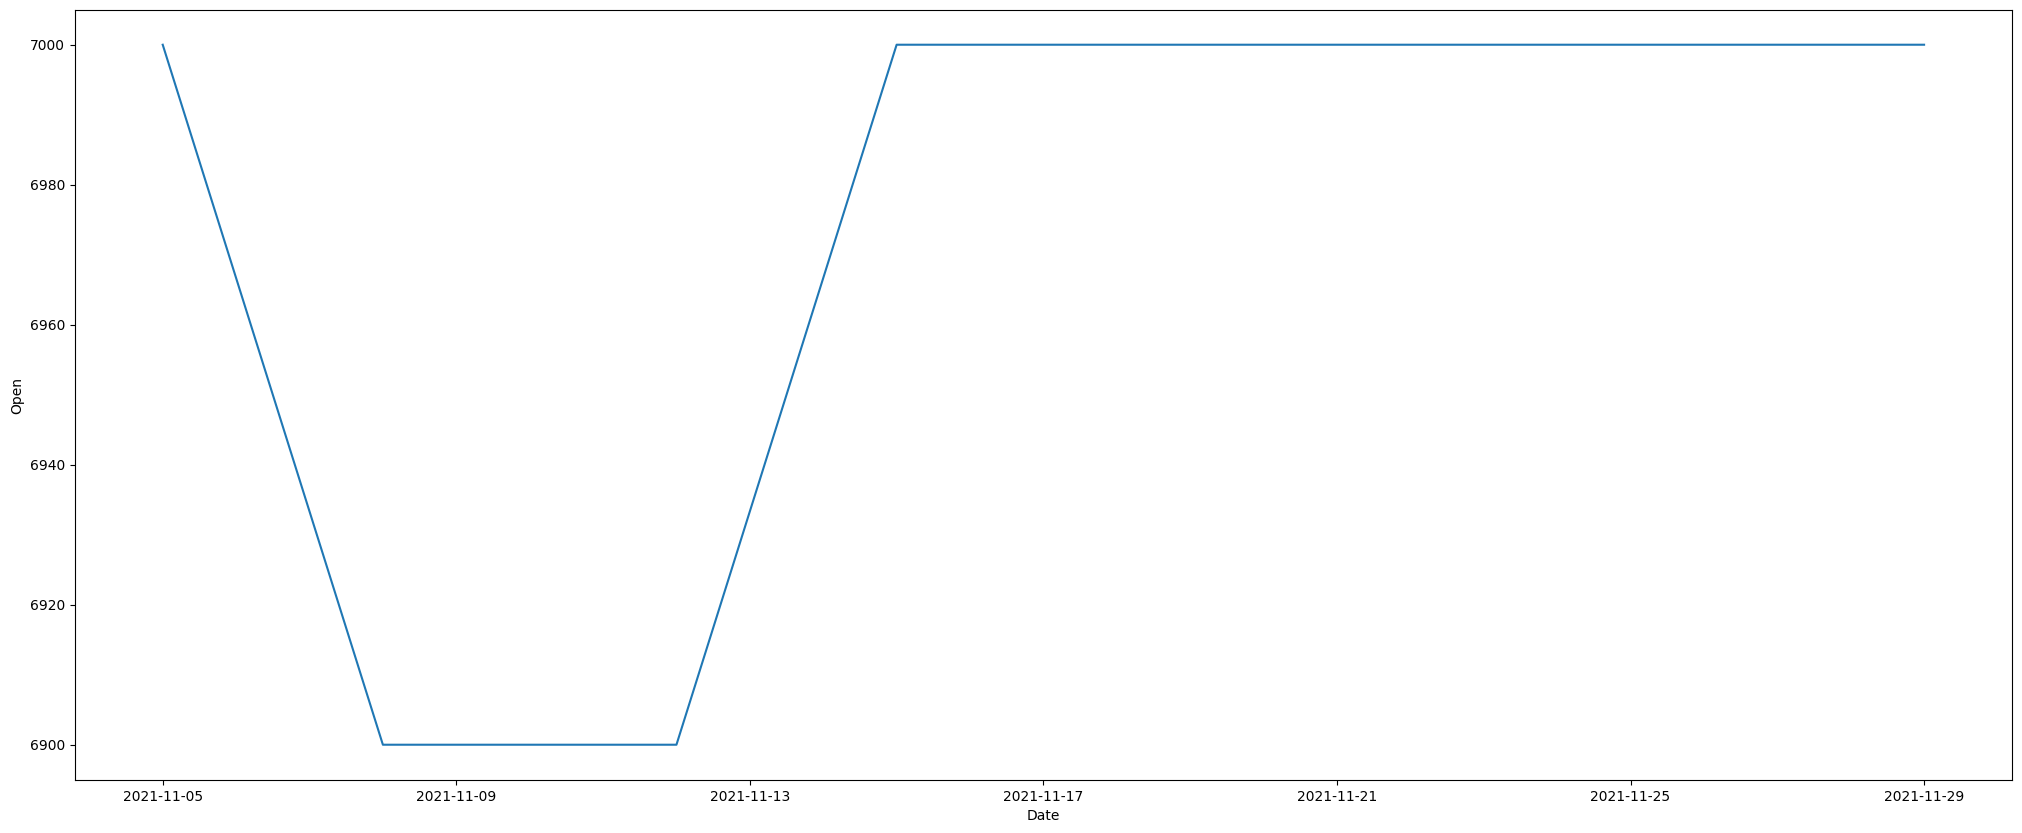

In [64]:

plt.figure(figsize=(25,10))
sns.lineplot(data = prices.query('SecuritiesCode == 2761 and Date > "2021-11-01"' ), x='Date', y= 'Open')

#sns.lineplot(data = prices.query('SecuritiesCode == 9994 and Date > "2021-11-01"' ), x='Date', y= 'Open')

<AxesSubplot:xlabel='Date', ylabel='Open'>

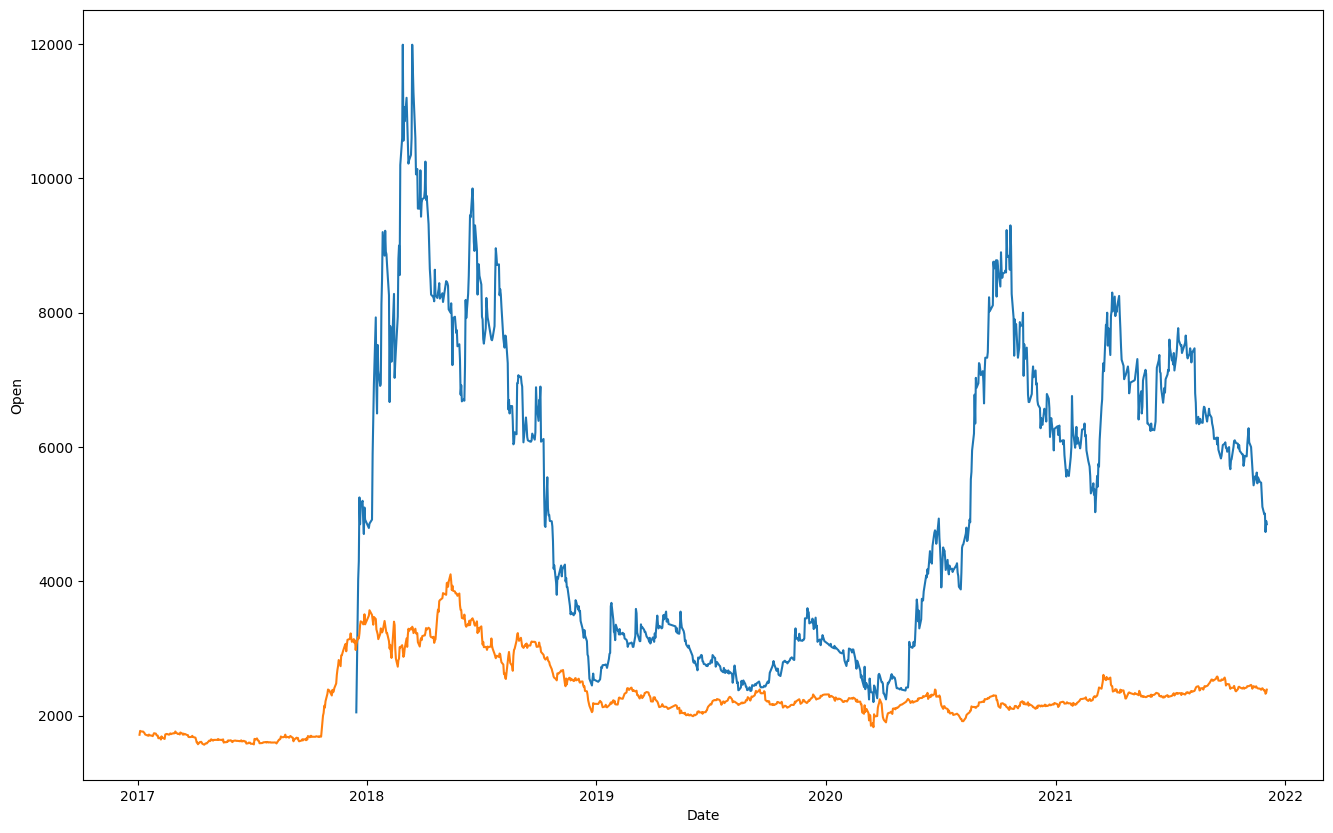

In [65]:
plt.figure(figsize=(16,10))
sns.lineplot(data = prices.query('SecuritiesCode == 3540'), x='Date', y= 'Open')
sns.lineplot(data = prices.query('SecuritiesCode == 9994'), x='Date', y= 'Open')


In [66]:
prices.isnull().sum().sort_values(ascending=False)

ExpectedDividend    2313666
Open                   7608
High                   7608
Low                    7608
Close                  7608
Target                  238
RowId                     0
Date                      0
SecuritiesCode            0
Volume                    0
AdjustmentFactor          0
SupervisionFlag           0
dtype: int64

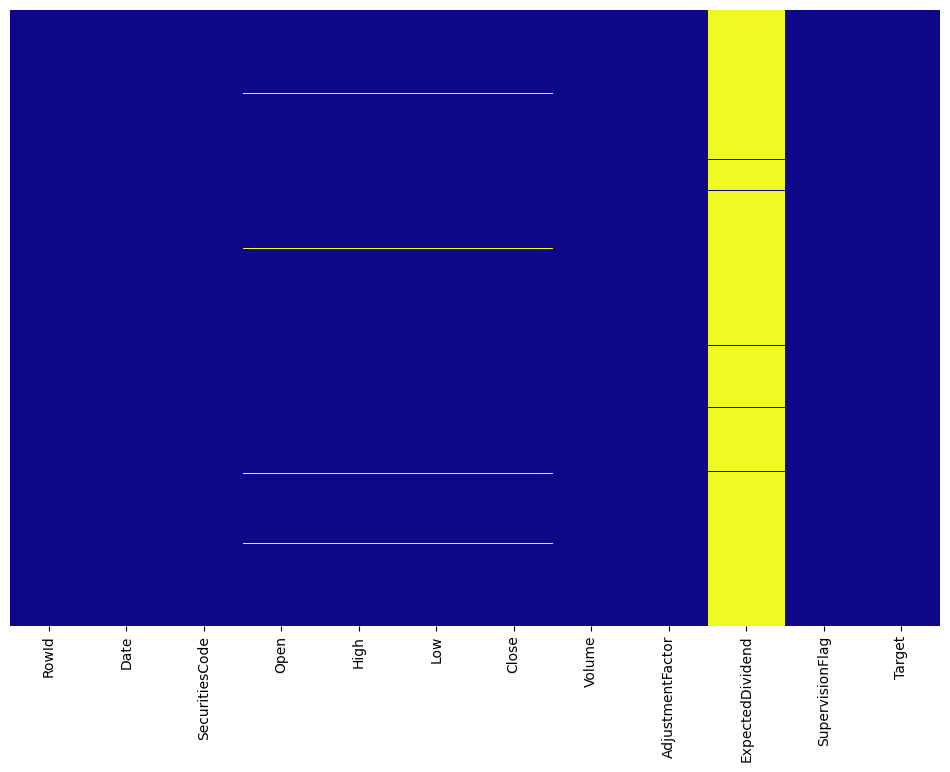

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(prices.isna(), cbar=False, cmap="plasma",yticklabels=False)
plt.show()

In [68]:
prices_nan = prices.query('Open != Open')
prices_nan.shape

(7608, 12)

In [69]:
prices_nan.Date.value_counts()

2020-10-01    1988
2017-03-16      15
2019-10-09      14
2019-04-04      14
2021-10-29      13
              ... 
2017-12-25       1
2017-12-26       1
2020-03-13       1
2018-01-04       1
2018-02-21       1
Name: Date, Length: 1175, dtype: int64

In [70]:
prices_nan[(prices_nan['Date']!='2020-10-01')].Date.value_counts().sort_values(ascending=True)

2017-11-02     1
2017-10-05     1
2019-12-06     1
2021-05-10     1
2017-10-03     1
              ..
2017-01-20    12
2021-10-29    13
2019-10-09    14
2019-04-04    14
2017-03-16    15
Name: Date, Length: 1174, dtype: int64

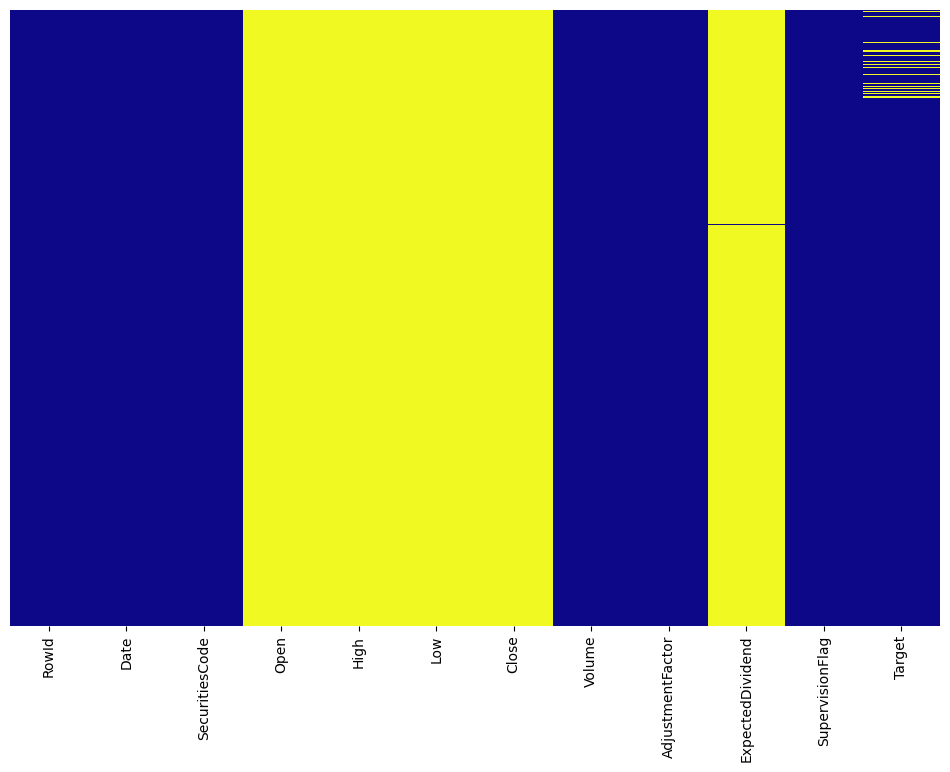

In [71]:
plt.figure(figsize=(12, 8))
sns.heatmap(prices_nan.isna(), cbar=False, cmap="plasma",yticklabels=False)
plt.show()

- forward fill for 1-10-2020
- / consecutive missing values of trades can be removed. the stock was taken out
- forward fill for missing values

In [72]:
prices_wo_nan = prices.query('Date != "2020-10-01" and Open == Open')

In [73]:
prices_wo_nan.isnull().sum().sort_values(ascending=False)

ExpectedDividend    2306082
RowId                     0
Date                      0
SecuritiesCode            0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
AdjustmentFactor          0
SupervisionFlag           0
Target                    0
dtype: int64

### SupervisionFlag
Flag of Securities Under Supervision & Securities to Be Delisted
https://www.jpx.co.jp/english/listing/market-alerts/supervision/00-archives/index.html )


If a stock is designated as Securities Under Supervision or Securities to Be Delisted during the private period, it will be excluded from investment after the date of designation

In [74]:
prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [75]:
prices.SupervisionFlag.value_counts()

False    2331036
True        1495
Name: SupervisionFlag, dtype: int64

In [76]:
from functions import plot_stock
w_flag = prices[(prices['SupervisionFlag']==True)]
w_flag.shape


(1495, 12)

In [77]:
w_flag.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
92438,20170315_6502,2017-03-15,6502,199.9,205.5,186.5,189.5,379973000,1.0,NaN,True,0.035403
94305,20170316_6502,2017-03-16,6502,188.6,192.2,181.6,183.6,211415000,1.0,NaN,True,0.033666
96172,20170317_6502,2017-03-17,6502,198.0,199.0,186.3,190.1,237833000,1.0,NaN,True,-0.012723
98042,20170321_6502,2017-03-21,6502,187.0,197.1,186.5,196.5,124884000,1.0,NaN,True,0.068557
99914,20170322_6502,2017-03-22,6502,194.0,195.7,192.4,194.0,54887000,1.0,NaN,True,0.075736


In [78]:
print(f'Securities codes with flag: {w_flag.SecuritiesCode.nunique()} ')
print(f'Securities codes: {w_flag.SecuritiesCode.unique()} : ')

Securities codes with flag: 15 
Securities codes: [6502 3540 6637 6465 7868 6067 6470 4526 5008 5486 3919 2729 3001 8806
 4699] : 


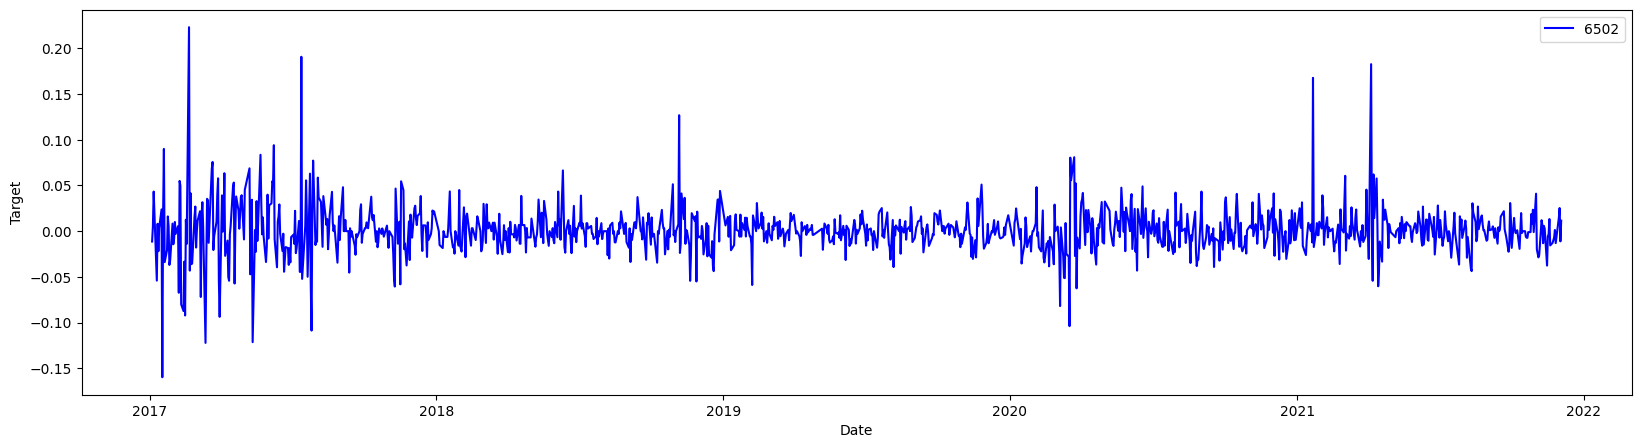

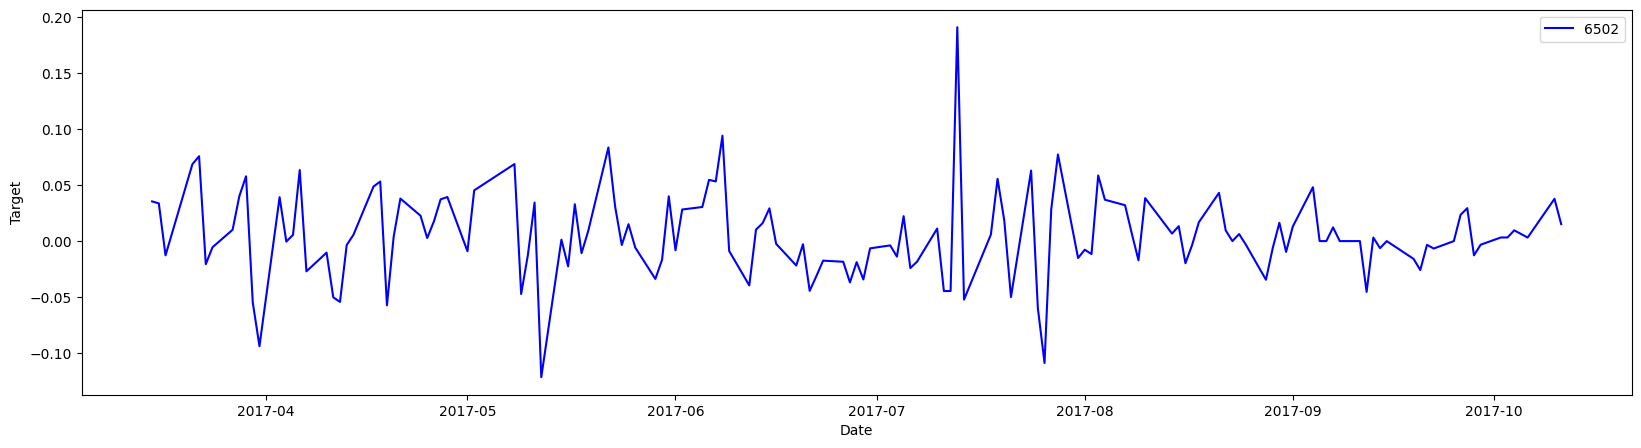

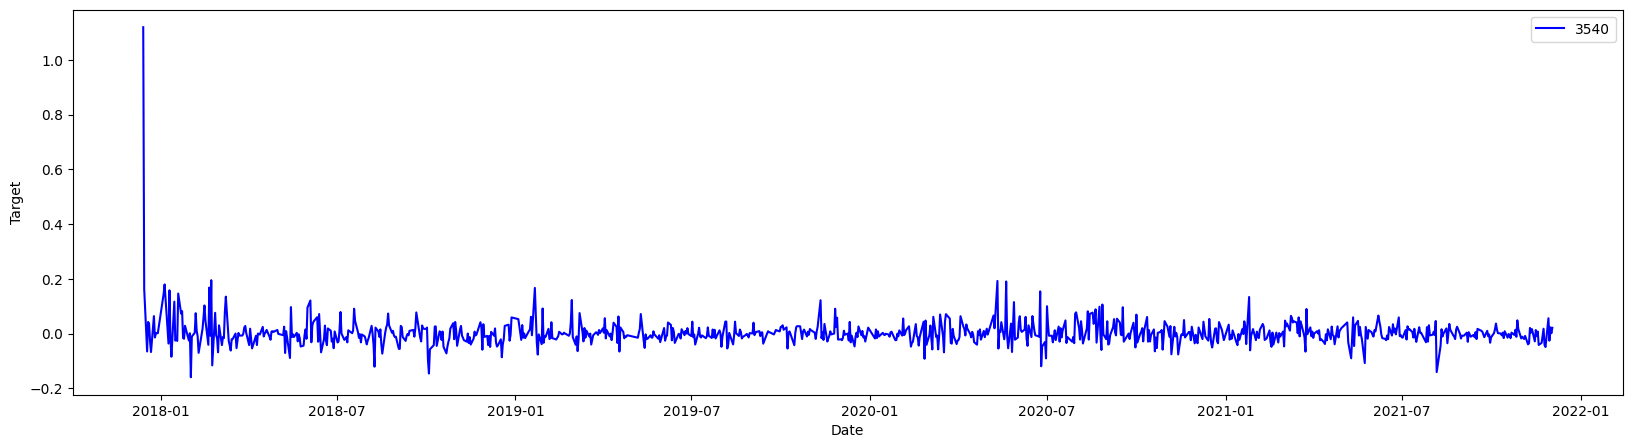

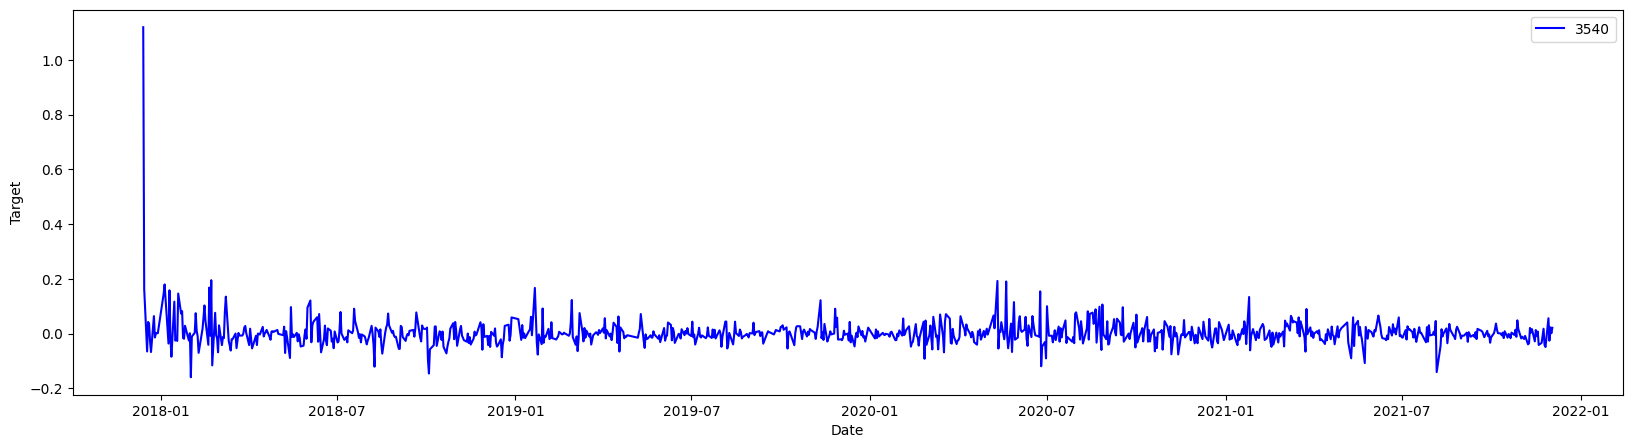

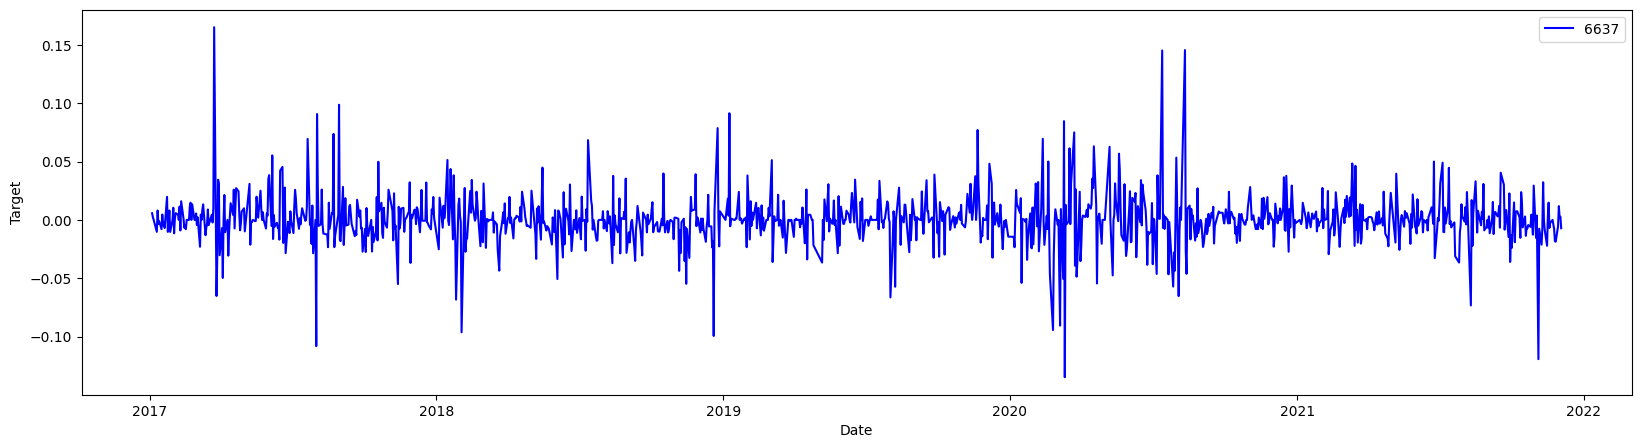

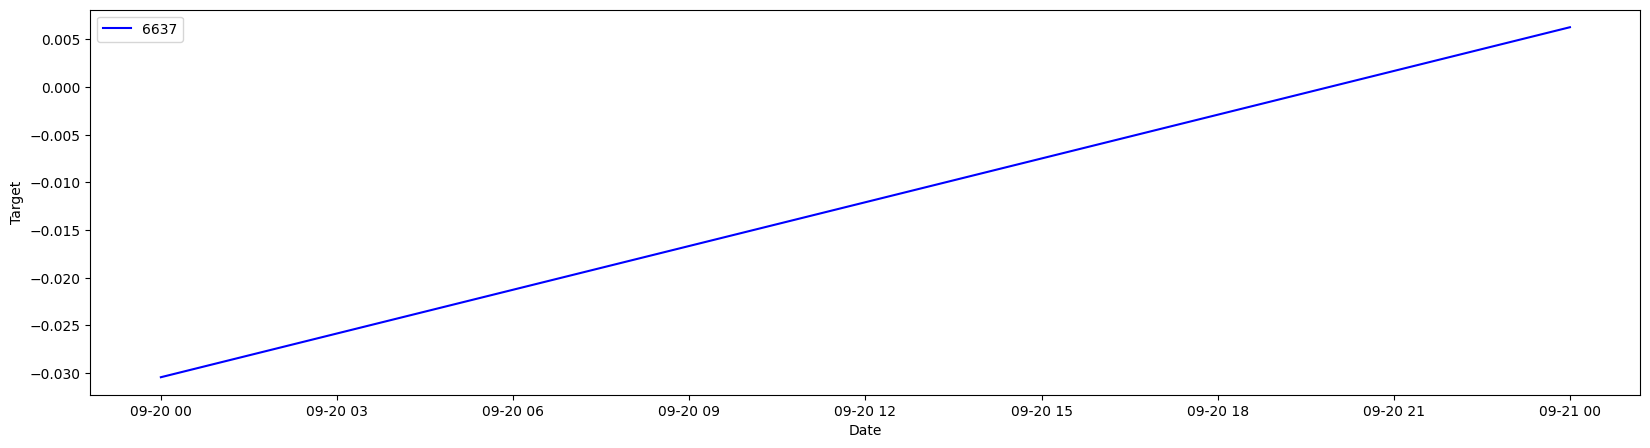

In [79]:
codes = w_flag.SecuritiesCode.unique()

for code in codes[:3]:
    plot_stock(prices, code)
    plot_stock(w_flag, code)
    plt.show()

In [80]:
date = w_flag.Date
date_desc = date.describe(datetime_is_numeric=True)
date_min = date_desc.loc['min']
date_max = date_desc.loc['max']
print('Data from {:%Y-%m-%d} to {:%Y-%m-%d}'
        .format(date_min, date_max))
print('Data observations {} '.format(
                 date.nunique()))

Data from 2017-03-15 to 2021-12-03
Data observations 1132 


the flags are set for the whole period of time

- how long has a stock a flag?

In [81]:
flag_day = {}
for code in codes: 
    current = w_flag.query('SecuritiesCode == @ code')
    date = current.Date
    date_desc = date.describe(datetime_is_numeric=True)
    date_min = date_desc.loc['min']
    date_max = date_desc.loc['max']
    flag_day[code] = [date_min, date_max, date.nunique()]


In [82]:
flag_stats = pd.DataFrame(flag_day).T
flag_stats.columns = ['start_flag', 'end_flag', 'days_w_flag']
flag_stats

,start_flag,end_flag,days_w_flag
6502,2017-03-15,2017-10-11,143
3540,2017-11-13,2021-12-03,989
6637,2018-09-20,2018-09-21,2
6465,2018-12-14,2018-12-27,9
7868,2019-01-17,2019-04-09,57
6067,2019-09-13,2019-09-26,8
6470,2019-09-17,2019-09-30,9
4526,2020-10-15,2020-10-28,10
5008,2020-12-15,2021-02-16,42
5486,2021-04-28,2021-12-03,147


encode flag: 

In [83]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(prices["SupervisionFlag"])
prices["SupervisionFlag"]=enc.transform(prices["SupervisionFlag"])

In [84]:
prices.SupervisionFlag.value_counts()

0    2331036
1       1495
Name: SupervisionFlag, dtype: int64

### Volume

In [85]:
missingValues(prices.Volume)

 missing Values: 0 (0.0%)


In [86]:
prices['Vol_Close'] = prices['Volume'] * prices['Close']

In [87]:
volumen_stock = prices.groupby('SecuritiesCode').sum()

In [88]:
top10 = volumen_stock.sort_values('Vol_Close', ascending=False).reset_index().head(10)

In [89]:
top10_codes = top10.SecuritiesCode

In [90]:
stock_list = pd.read_csv('../data/stock_list.csv', parse_dates=['EffectiveDate', 'TradeDate'])
stock_list_top10 = stock_list[stock_list['SecuritiesCode'].isin(top10_codes)]
#del stock_list
stock_list_top10

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
2804,6758,2021-12-30,SONY GROUP CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,14475.0,1.261082e+09,1.825416e+13,True
2867,6861,2021-12-30,KEYENCE CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,72280.0,2.432077e+08,1.757905e+13,True
2925,6954,2021-12-30,FANUC CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,24380.0,2.019094e+08,4.922551e+12,True
3065,7203,2021-12-30,TOYOTA MOTOR CORPORATION,First Section (Domestic),Prime Market,3700,Transportation Equipment,6,AUTOMOBILES & TRANSPORTATION EQUIPMENT,1,TOPIX Core30,20211230.0,2105.5,1.631499e+10,3.435121e+13,True
3535,7974,2021-12-30,"Nintendo Co.,Ltd.",First Section (Domestic),Prime Market,3800,Other Products,10,"IT & SERVICES, OTHERS",1,TOPIX Core30,20211230.0,53650.0,1.298690e+08,6.967472e+12,True
3577,8035,2021-12-30,Tokyo Electron Limited,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,66280.0,1.572109e+08,1.041994e+13,True
3732,8306,2021-12-30,"Mitsubishi UFJ Financial Group,Inc.",First Section (Domestic),Prime Market,7050,Banks,15,BANKS,1,TOPIX Core30,20211230.0,624.9,1.328200e+10,8.299919e+12,True
3735,8316,2021-12-30,"Sumitomo Mitsui Financial Group,Inc.",First Section (Domestic),Prime Market,7050,Banks,15,BANKS,1,TOPIX Core30,20211230.0,3943.0,1.374362e+09,5.419110e+12,True
4403,9983,2021-12-30,"FAST RETAILING CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,2,TOPIX Large70,20211230.0,65310.0,1.060737e+08,6.927670e+12,True
4404,9984,2021-12-30,SoftBank Group Corp.,First Section (Domestic),Prime Market,5250,Information & Communication,10,"IT & SERVICES, OTHERS",1,TOPIX Core30,20211230.0,5434.0,1.722954e+09,9.362531e+12,True


In [91]:
stock_list_top10 = stock_list[stock_list['SecuritiesCode'].isin(top10_codes)]
stock_list_top10

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
2804,6758,2021-12-30,SONY GROUP CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,14475.0,1.261082e+09,1.825416e+13,True
2867,6861,2021-12-30,KEYENCE CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,72280.0,2.432077e+08,1.757905e+13,True
2925,6954,2021-12-30,FANUC CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,24380.0,2.019094e+08,4.922551e+12,True
3065,7203,2021-12-30,TOYOTA MOTOR CORPORATION,First Section (Domestic),Prime Market,3700,Transportation Equipment,6,AUTOMOBILES & TRANSPORTATION EQUIPMENT,1,TOPIX Core30,20211230.0,2105.5,1.631499e+10,3.435121e+13,True
3535,7974,2021-12-30,"Nintendo Co.,Ltd.",First Section (Domestic),Prime Market,3800,Other Products,10,"IT & SERVICES, OTHERS",1,TOPIX Core30,20211230.0,53650.0,1.298690e+08,6.967472e+12,True
3577,8035,2021-12-30,Tokyo Electron Limited,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,66280.0,1.572109e+08,1.041994e+13,True
3732,8306,2021-12-30,"Mitsubishi UFJ Financial Group,Inc.",First Section (Domestic),Prime Market,7050,Banks,15,BANKS,1,TOPIX Core30,20211230.0,624.9,1.328200e+10,8.299919e+12,True
3735,8316,2021-12-30,"Sumitomo Mitsui Financial Group,Inc.",First Section (Domestic),Prime Market,7050,Banks,15,BANKS,1,TOPIX Core30,20211230.0,3943.0,1.374362e+09,5.419110e+12,True
4403,9983,2021-12-30,"FAST RETAILING CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,2,TOPIX Large70,20211230.0,65310.0,1.060737e+08,6.927670e+12,True
4404,9984,2021-12-30,SoftBank Group Corp.,First Section (Domestic),Prime Market,5250,Information & Communication,10,"IT & SERVICES, OTHERS",1,TOPIX Core30,20211230.0,5434.0,1.722954e+09,9.362531e+12,True


In [92]:
stock_list_top10

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
2804,6758,2021-12-30,SONY GROUP CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,14475.0,1.261082e+09,1.825416e+13,True
2867,6861,2021-12-30,KEYENCE CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,72280.0,2.432077e+08,1.757905e+13,True
2925,6954,2021-12-30,FANUC CORPORATION,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,24380.0,2.019094e+08,4.922551e+12,True
3065,7203,2021-12-30,TOYOTA MOTOR CORPORATION,First Section (Domestic),Prime Market,3700,Transportation Equipment,6,AUTOMOBILES & TRANSPORTATION EQUIPMENT,1,TOPIX Core30,20211230.0,2105.5,1.631499e+10,3.435121e+13,True
3535,7974,2021-12-30,"Nintendo Co.,Ltd.",First Section (Domestic),Prime Market,3800,Other Products,10,"IT & SERVICES, OTHERS",1,TOPIX Core30,20211230.0,53650.0,1.298690e+08,6.967472e+12,True
3577,8035,2021-12-30,Tokyo Electron Limited,First Section (Domestic),Prime Market,3650,Electric Appliances,9,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,1,TOPIX Core30,20211230.0,66280.0,1.572109e+08,1.041994e+13,True
3732,8306,2021-12-30,"Mitsubishi UFJ Financial Group,Inc.",First Section (Domestic),Prime Market,7050,Banks,15,BANKS,1,TOPIX Core30,20211230.0,624.9,1.328200e+10,8.299919e+12,True
3735,8316,2021-12-30,"Sumitomo Mitsui Financial Group,Inc.",First Section (Domestic),Prime Market,7050,Banks,15,BANKS,1,TOPIX Core30,20211230.0,3943.0,1.374362e+09,5.419110e+12,True
4403,9983,2021-12-30,"FAST RETAILING CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,2,TOPIX Large70,20211230.0,65310.0,1.060737e+08,6.927670e+12,True
4404,9984,2021-12-30,SoftBank Group Corp.,First Section (Domestic),Prime Market,5250,Information & Communication,10,"IT & SERVICES, OTHERS",1,TOPIX Core30,20211230.0,5434.0,1.722954e+09,9.362531e+12,True


### Seasonality

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
def seasonality(df, feature):
        #df_code[f'logprice_' + feature] = np.log(df_code[feature])


        decomposition = seasonal_decompose(x=df[feature], 
                                   model='additive',
                                   period=30)

        df[f'detrend_' + feature] = decomposition.observed
        df[f'trend_' + feature] = decomposition.trend
        df[f'season_' + feature] = decomposition.seasonal
        df[f'error_' + feature] = decomposition.resid

In [94]:
prices = pd.read_csv('../data/train_files/stock_prices.csv', parse_dates=[1])

In [95]:
df_code = df_security_code(prices, 8198)
df_code.ffill(inplace=True)
df_code.dropna(inplace=True)

In [96]:
seasonality(df_code, 'Close')

       
        

In [97]:
#df_code.columns
cols = ['Close', 'detrend_Close', 'trend_Close', 'season_Close',
       'error_Close']
df_code[cols].tail()


,Close,detrend_Close,trend_Close,season_Close,error_Close
2324138,2610.0,2610.0,NaN,6.729592,NaN
2326138,2613.0,2613.0,NaN,-0.721724,NaN
2328138,2605.0,2605.0,NaN,-11.692338,NaN
2330138,2589.0,2589.0,NaN,-11.413391,NaN
2332138,2609.0,2609.0,NaN,-12.912075,NaN


### Target
Change ratio of adjusted closing price between t+2 and t+1 where t+0 is TradeDate <br>
r(k,t) = C(k, t+2) - C(k, t+1) / C(k, t+1)

- adjusted stock price is used

(-0.4, 0.4)

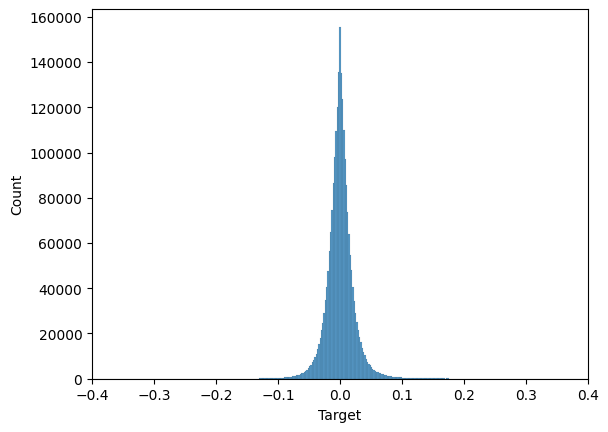

In [98]:
sns.histplot(prices.Target, bins=800, )
plt.xlim([-0.4, 0.4])

target for a stock

In [99]:
def plot_target(df, Code):
    single_stock = df.query('SecuritiesCode==@Code')
    plt.figure(figsize=(20,5))
    sns.lineplot(data=single_stock, y='Close', x='Date')
    ax2 = plt.twinx()
    sns.lineplot(data=single_stock, y='Target', x='Date', color='red')  

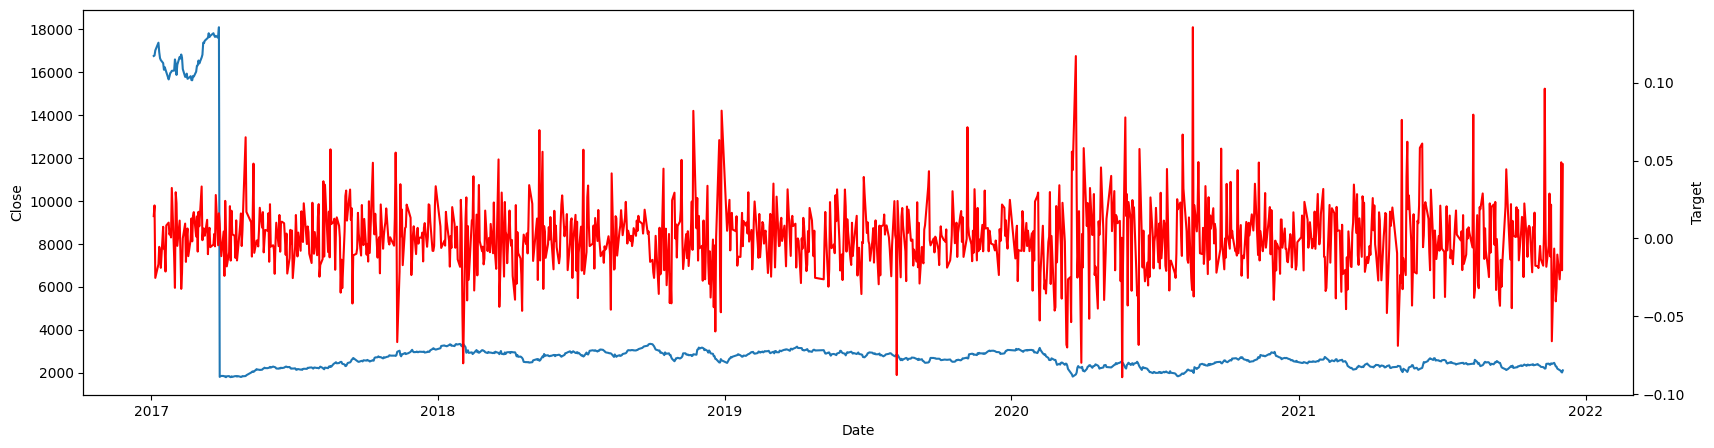

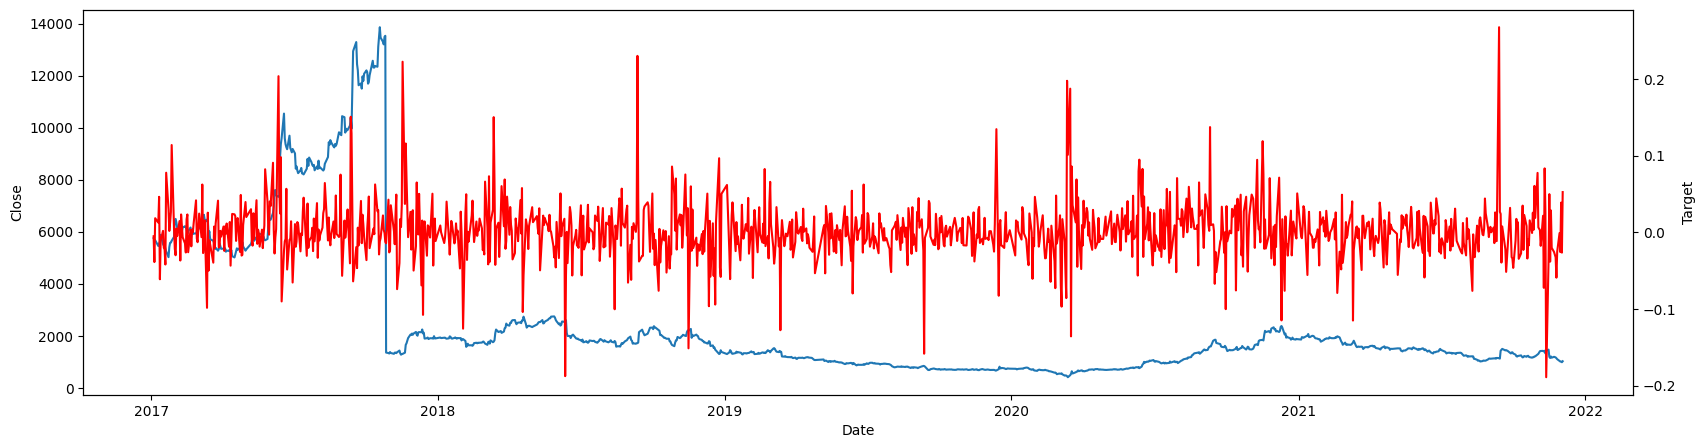

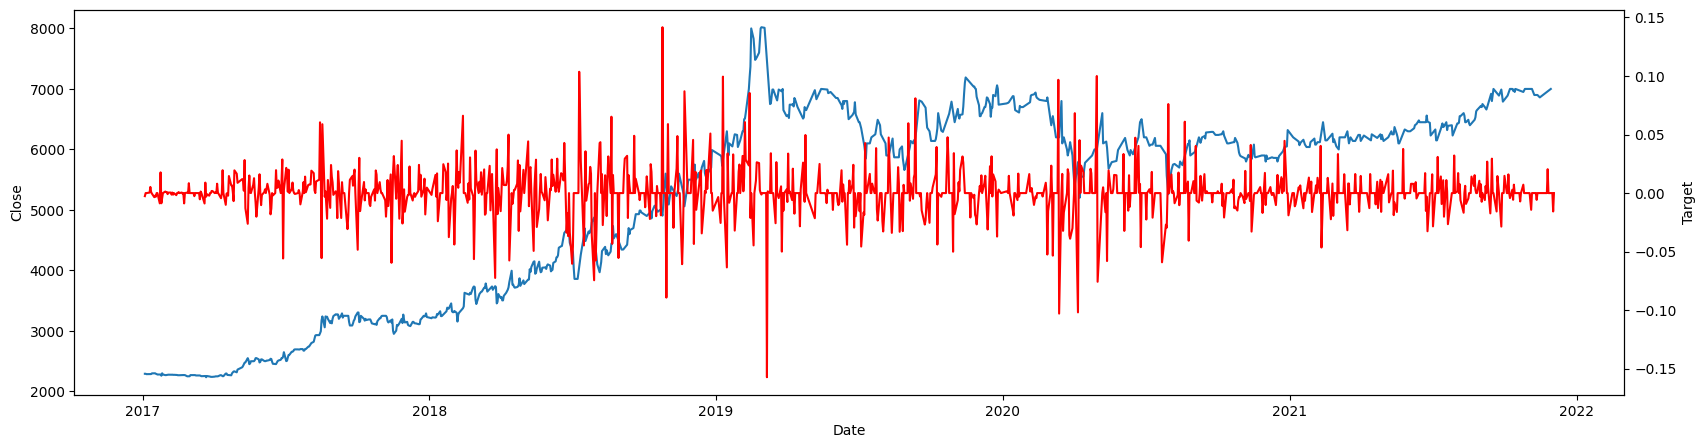

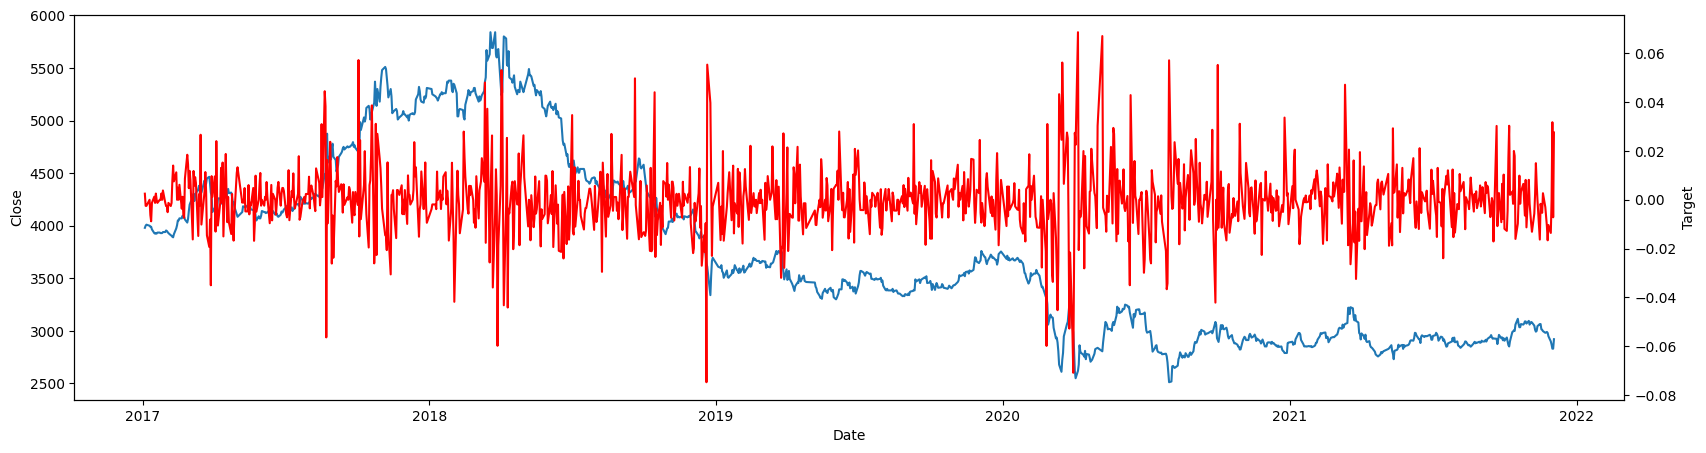

In [100]:
for i in [8876, 6630, 2761, 2753]:
    plot_target(prices, i)

#### - Rank
for each day

In [101]:
prices.Date.nunique()

1202

In [102]:
prices_rank = pd.DataFrame(columns = prices.columns)

In [103]:
# only one day
def calculate_rank(df, day):
    df = prices[(prices['Date']== day)]
    df.loc[:, 'Rank'] = df['Target'].rank(ascending=False, method='first') - 1
    
    return df

df = calculate_rank(prices, prices.Date.unique()[0])
one_day_rank = pd.concat([prices_rank, df], axis=0)



In [104]:
def daily_spread_return(df, day):
    # calculate rank 
    df = prices[(prices['Date']== day)]
    df.loc[:, 'Rank'] = df['Target'].rank(ascending=False, method='first') - 1

    # calculate weights and weighted_target
    weights = np.linspace(start = 2, stop=1, num=200)

    # sum_up
    top200 = df.sort_values('Rank').iloc[:200,:]
    top200['Weights'] = weights
    top200['weigh_Target'] = top200['Target'] * top200['Weights']
    sum_up = top200['weigh_Target'].sum()/top200['Weights'].mean()

    # sum_down
    bottom200 = one_day_rank.sort_values('Rank').iloc[-200:,:].sort_values('Rank', ascending=False)
    bottom200['Weights'] = np.linspace(start = 2, stop=1, num=200)
    bottom200['weigh_Target'] = bottom200['Target'] * bottom200['Weights']
    sum_down = bottom200['weigh_Target'].sum()/bottom200['Weights'].mean()

    # return daily_spread return
    return  df.SecuritiesCode.nunique(), sum_up - sum_down

In [105]:
stocks_per_day = {}

def calculate_rank(df, day):
    df = prices[(prices['Date']== day)]
    df.loc[:, 'Rank'] = df['Target'].rank(ascending=False, method='first') - 1
    
    return df

prices_rank = pd.DataFrame(columns = prices.columns)

for day in tqdm(prices.Date.unique()):
    stocks, dsr = daily_spread_return(prices, day)
    stocks_per_day[day] = [stocks, dsr]

100%|██████████| 1202/1202 [00:14<00:00, 83.03it/s]


In [106]:
stocks_day = pd.DataFrame(stocks_per_day).T
stocks_day.columns = ['SecuritiesCode_s', 'daily_spread_return']
stocks_day

,SecuritiesCode_s,daily_spread_return
2017-01-04,1865.0,12.037530
2017-01-05,1865.0,12.416911
2017-01-06,1865.0,12.005566
2017-01-10,1865.0,9.933094
2017-01-11,1865.0,12.213413
...,...,...
2021-11-29,2000.0,12.631975
2021-11-30,2000.0,10.706950
2021-12-01,2000.0,17.968421
2021-12-02,2000.0,10.951558


In [107]:
stocks_day.nunique()

SecuritiesCode_s        113
daily_spread_return    1202
dtype: int64

In [108]:
df = df_security_code(prices)
#df_in = df.query('Date > datetime.date(2021, 9, 21) and Date < datetime.date(2021, 10, 6)')
df_in = df.query('Date > "2021-9-21" and Date < "2021-10-6"')


<AxesSubplot:xlabel='Date', ylabel='Close'>

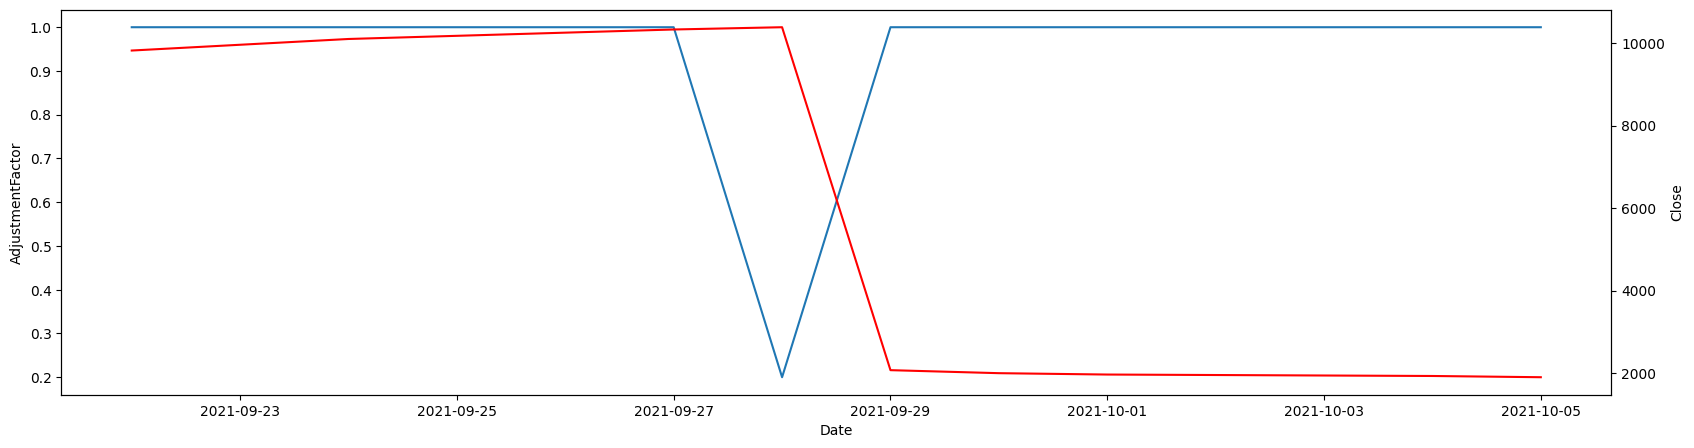

In [109]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_in, y='AdjustmentFactor', x='Date')
ax2 = plt.twinx()
sns.lineplot(data=df_in, y='Close', x='Date', color='red')
#plt.xlim([datetime.date(2021, 9, 1), datetime.date(2021, 12, 3)])

only one change in adjustment factor for code 7203 is justified

- Test


prices.shape

In [110]:
prices.shape

(2332531, 12)

In [111]:
codes = [8194, 8198, 8200]

d8194 = df_security_code(prices, 8194)
d8198 = df_security_code(prices, 8198)
d8200 = df_security_code(prices, 8200)

In [112]:
df_8194 = d8194[['Date', 'Close']].set_index(['Date'])
df_8194.head()

,Close
Date,
2017-01-04,3380.0
2017-01-05,3375.0
2017-01-06,3365.0
2017-01-10,3295.0
2017-01-11,3275.0


In [113]:
df = pd.DataFrame()
for cod in codes: 
    df_code = df_security_code(prices, cod)
    df_code = df_code[['Date', 'Close']].set_index(['Date'])

    df = pd.concat([df, df_code], axis=1)


In [114]:
df.head()

,Close,Close,Close
Date,,,
2017-01-04,3380.0,1902.0,2298.0
2017-01-05,3375.0,1907.0,2299.0
2017-01-06,3365.0,1905.0,2302.0
2017-01-10,3295.0,1906.0,2323.0
2017-01-11,3275.0,1915.0,2324.0


## Trades

In [115]:
trades = pd.read_csv('../data/train_files/trades.csv')
trades.shape
trades.head(2)

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,...,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
trades.shape


(1712, 56)

only  nan values?

In [117]:
del trades

# Features engineering

## 2. Adjusted prices
to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares/)

In [118]:
prices.AdjustmentFactor.unique()

array([ 1.        ,  0.5       ,  5.        ,  0.33333333,  0.83333333,
        0.25      ,  0.90909091,  0.1       , 10.        ,  0.2       ,
        0.95238095,  2.        ,  0.14285714,  0.66666667,  0.86956522,
        0.76923077,  0.8       ,  4.        , 20.        ])

- amount of stocks for each adjustment factor

In [119]:

for i in sorted(prices.AdjustmentFactor.unique()):
    print( 'adjustment factor = {}   \t:  {} trades'.format(
        round(i,2), prices[(prices['AdjustmentFactor']==i)].Date.count()
    ))
   

adjustment factor = 0.1   	:  3 trades
adjustment factor = 0.14   	:  1 trades
adjustment factor = 0.2   	:  20 trades
adjustment factor = 0.25   	:  33 trades
adjustment factor = 0.33   	:  59 trades
adjustment factor = 0.5   	:  328 trades
adjustment factor = 0.67   	:  4 trades
adjustment factor = 0.77   	:  6 trades
adjustment factor = 0.8   	:  2 trades
adjustment factor = 0.83   	:  6 trades
adjustment factor = 0.87   	:  1 trades
adjustment factor = 0.91   	:  10 trades
adjustment factor = 0.95   	:  3 trades
adjustment factor = 1.0   	:  2331801 trades
adjustment factor = 2.0   	:  36 trades
adjustment factor = 4.0   	:  1 trades
adjustment factor = 5.0   	:  113 trades
adjustment factor = 10.0   	:  103 trades
adjustment factor = 20.0   	:  1 trades


In [120]:
def adjust_price(df):
    # cumulative adjustment factor considering the day shift
    df.sort_values('Date')
    df.loc[:,'CAF'] = df['AdjustmentFactor'].cumprod().shift(1)
    # fill nan values
    df.CAF.fillna(1, inplace=True)
    # prices to be adjusted
    prices =[ 'Open', 'High', 'Low', 'Close']

    for x in prices:
        df.loc[:,'ad_' + str(x)]  = df[x] / df['CAF']
    
    # adjust volume
    df['ad_Volume'] = df['Volume'] * df['CAF']
    df.drop('CAF', axis=1, inplace=True)

     # adjust target
    df.sort_values('Date')
    df['ad_Close_1'] = df['ad_Close'].shift(-1)
    df['ad_Close_2'] = df['ad_Close'].shift(-2)
    df['ad_Target'] = (df['ad_Close_2']-df['ad_Close_1'])/df['ad_Close_1']
    df.drop(['ad_Close_1', 'ad_Close_2'], axis=1, inplace=True)

    return df

In [121]:
# create an empty new DataFrame
adjusted_data = pd.DataFrame(columns = prices.columns)

for i in tqdm([8876, 6630, 7453, 7638]): #tqdm(prices.SecuritiesCode.unique()):
    df = prices.query('SecuritiesCode ==@i')
    adjusted_df = adjust_price(df)
    adjusted_data = pd.concat([adjusted_data, adjusted_df ], axis=0)

100%|██████████| 4/4 [00:00<00:00, 15.31it/s]


In [122]:
def plot_stock(df, Code):
    single_stock = df.query('SecuritiesCode==@Code')
    plt.figure(figsize=(20,5))
    sns.lineplot(data=single_stock, y='Close', x='Date')
    ax2 = plt.twinx()
    sns.lineplot(data=single_stock, y='ad_Close', x='Date', color='red')


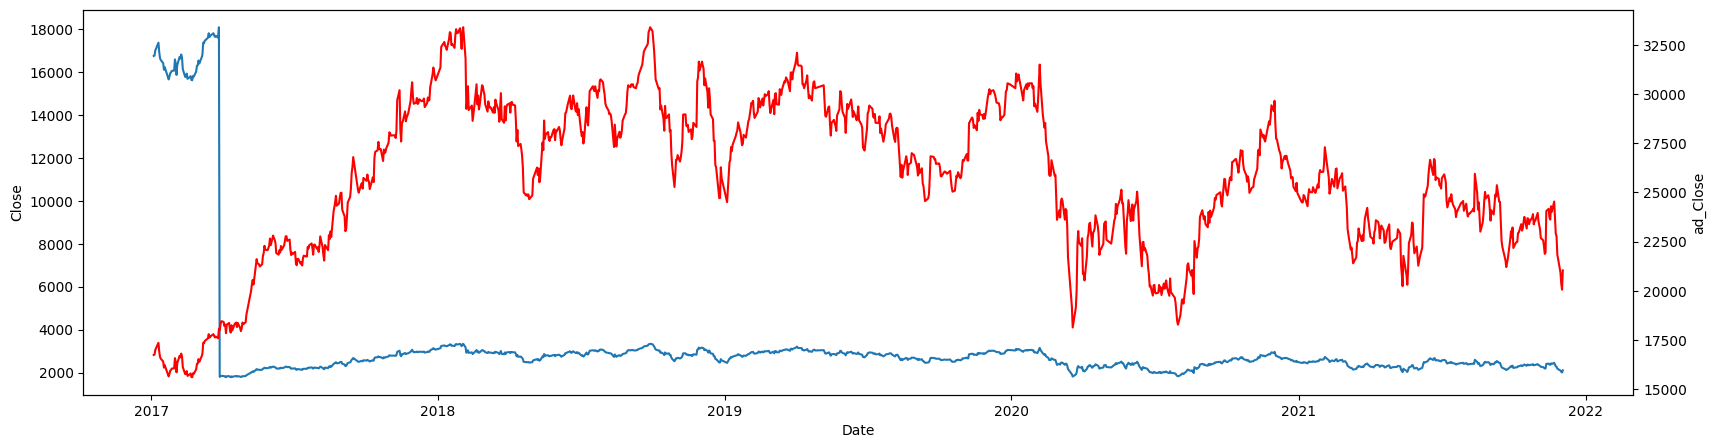

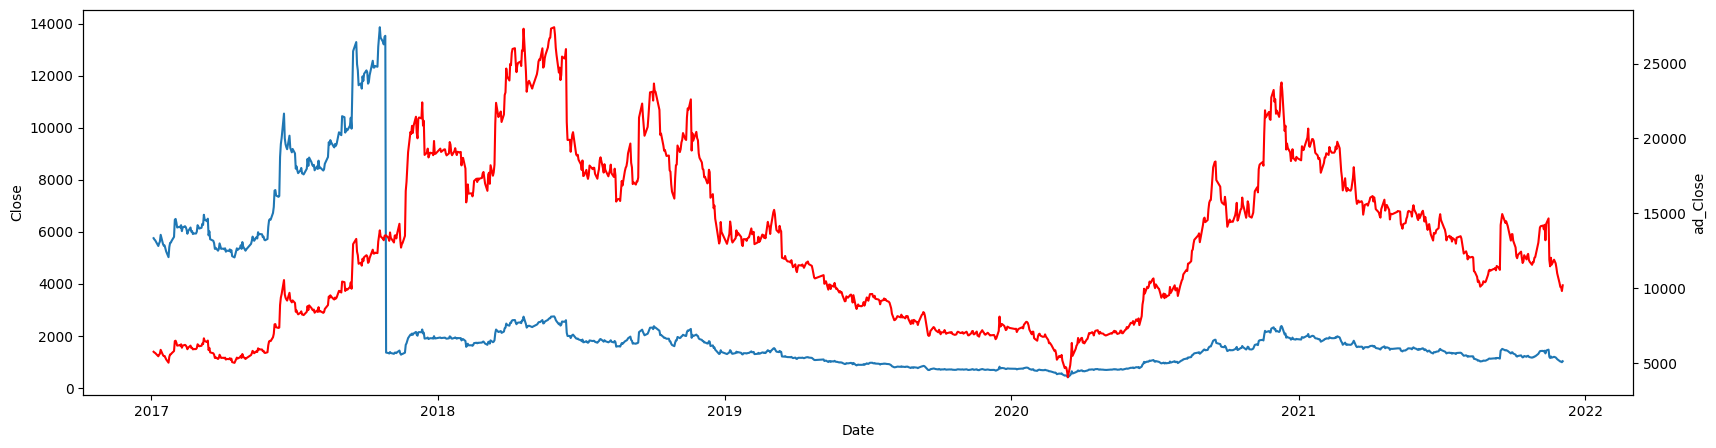

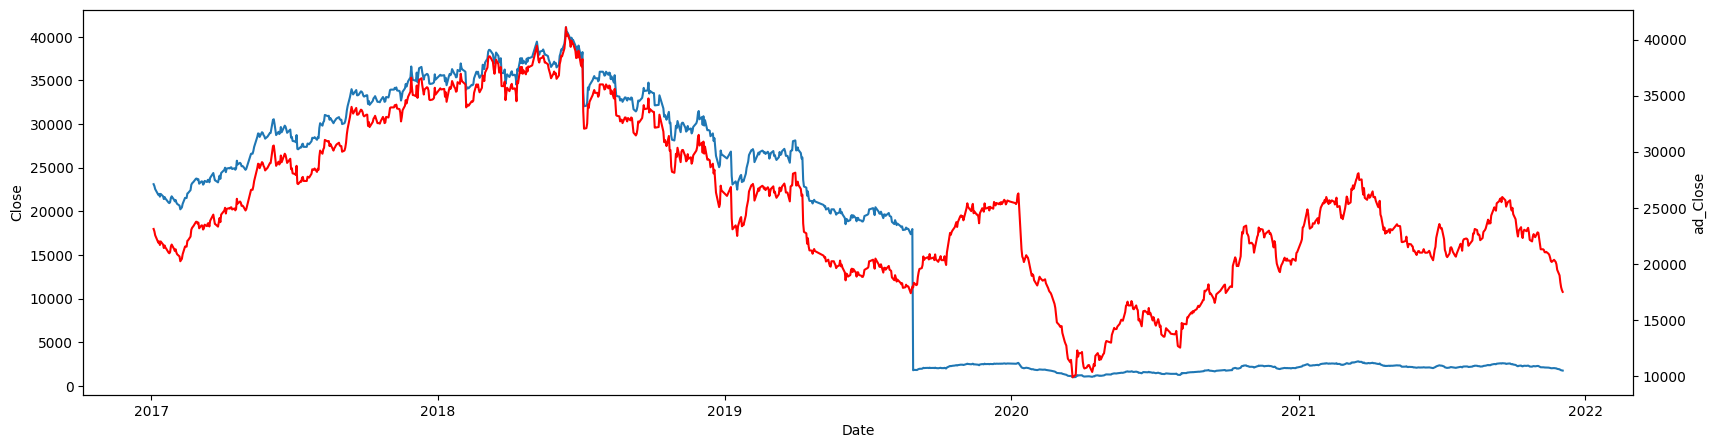

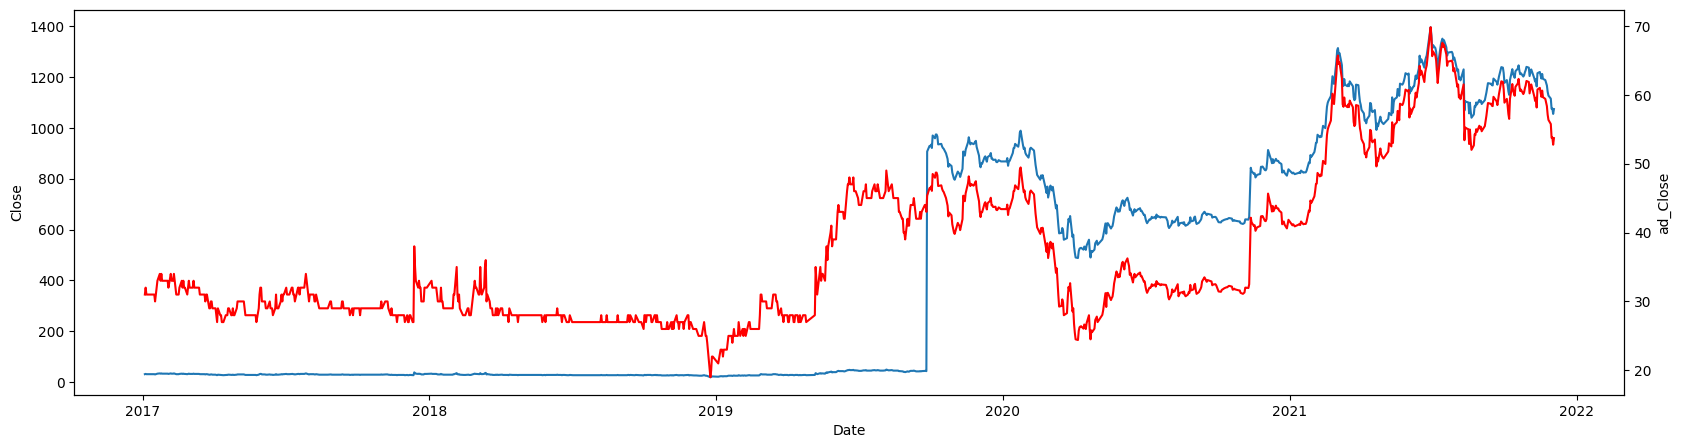

In [123]:
for i in [8876, 6630, 7453, 7638]:
    plot_stock(adjusted_data, i)

../data/train_files/stock_prices_ad.csvthe adjusted value was calculated with process_adjusted_price.py and save in : 

In [124]:
adjusted_data = pd.read_csv('../data/train_files/stock_prices_ad.csv', parse_dates=[2], index_col=0)
adjusted_data.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target
1483,20170104_8194,2017-01-04,8194,3325.0,3390.0,3300.0,3380.0,36100,1.0,NaN,False,-0.002963,3325.0,3390.0,3300.0,3380.0,36100.0,-0.002963
3348,20170105_8194,2017-01-05,8194,3395.0,3420.0,3360.0,3375.0,19400,1.0,NaN,False,-0.020802,3395.0,3420.0,3360.0,3375.0,19400.0,-0.020802


- close distribution

<AxesSubplot:xlabel='ad_Close', ylabel='Count'>

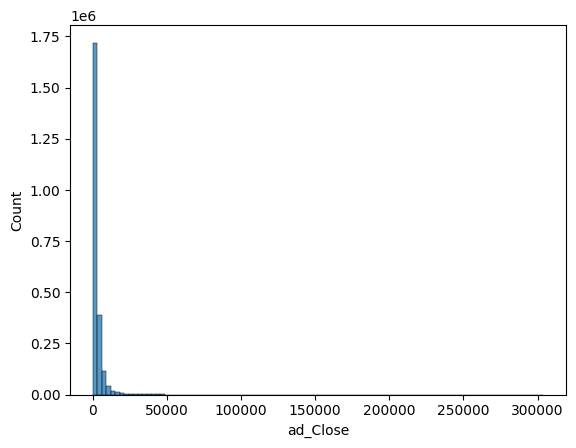

In [125]:
sns.histplot(adjusted_data.ad_Close, bins=100)

In [126]:
pd.DataFrame(adjusted_data.ad_Close.describe()).T

,count,mean,std,min,25%,50%,75%,max
ad_Close,2324923.0,2853.056437,5469.634951,10.3,849.0,1686.0,3150.0,303920.0


In [127]:
adjusted_data.sort_values('ad_Close', ascending=False).SecuritiesCode.unique()[:5]

array([6861, 6920, 9983, 3962, 4488])

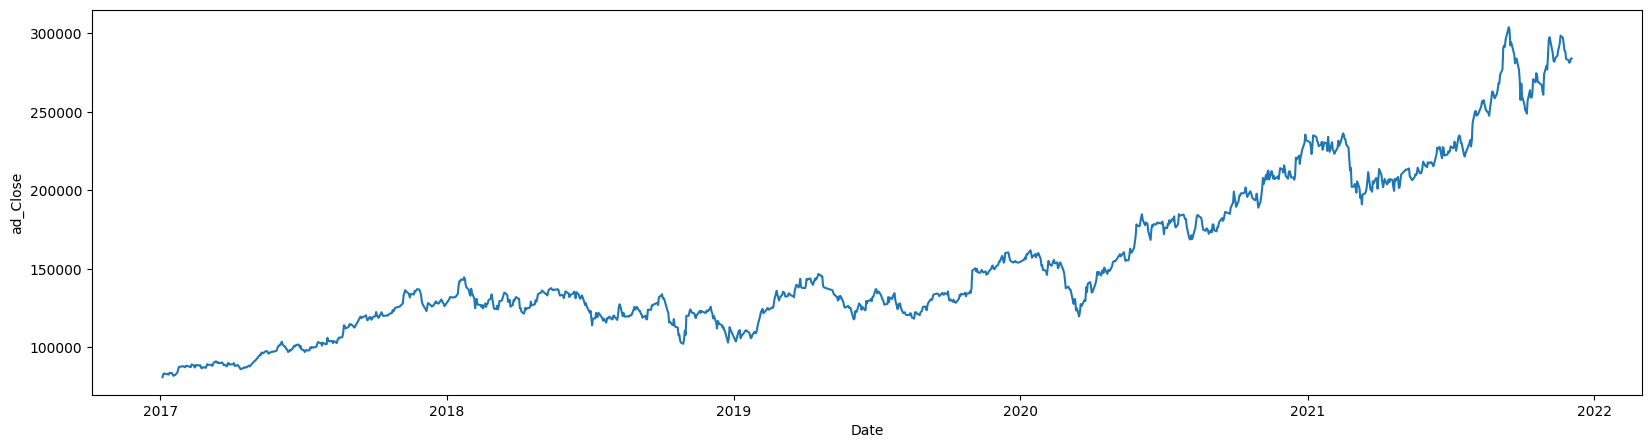

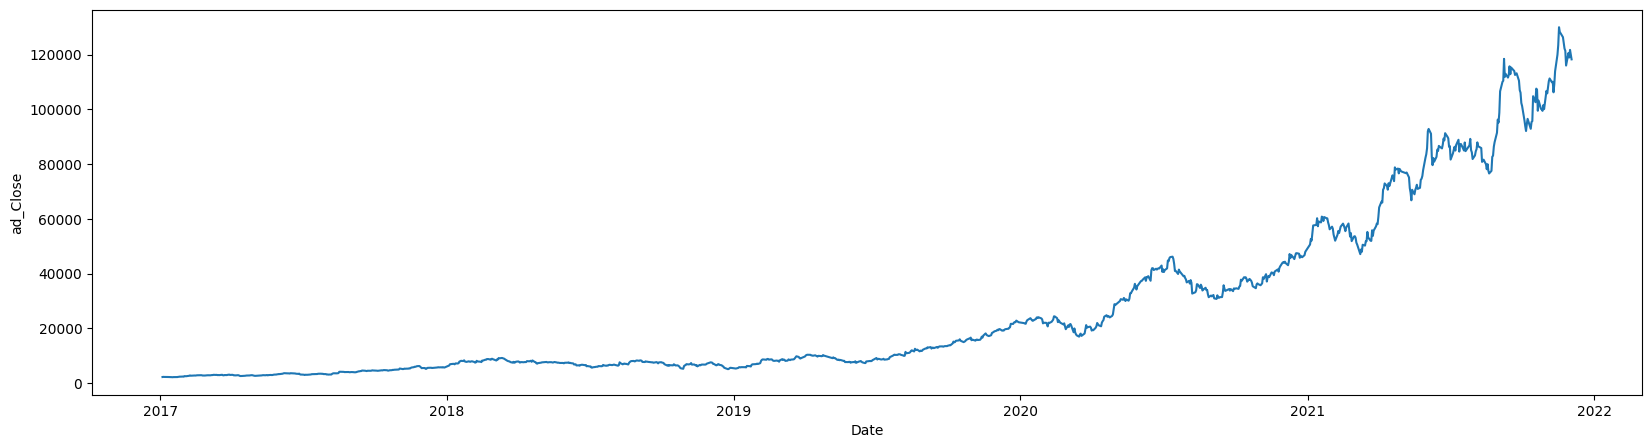

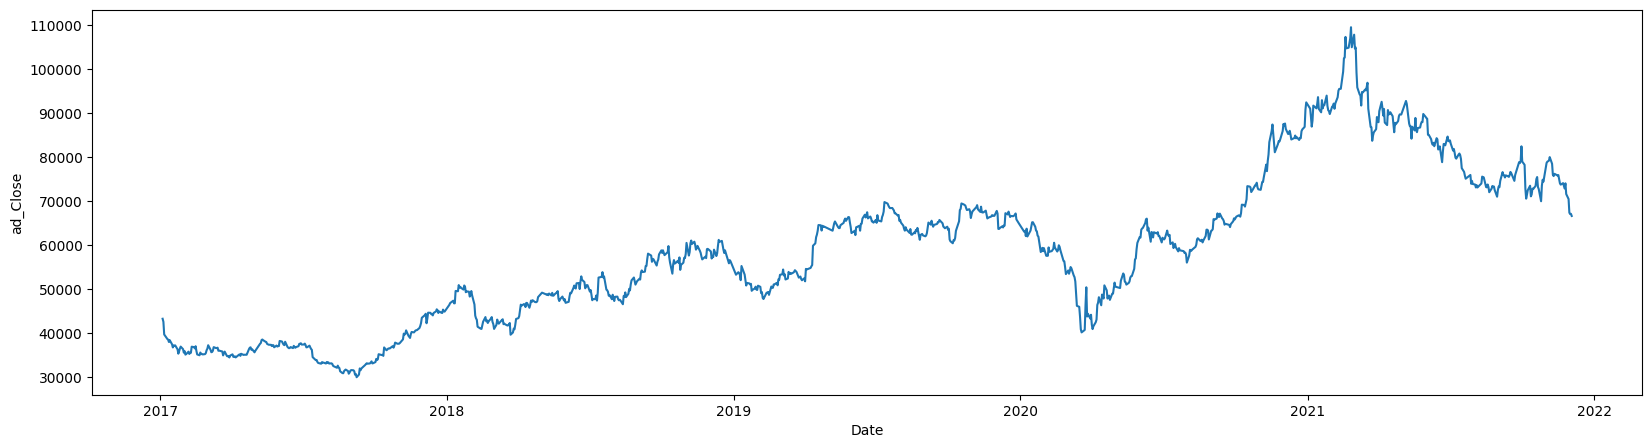

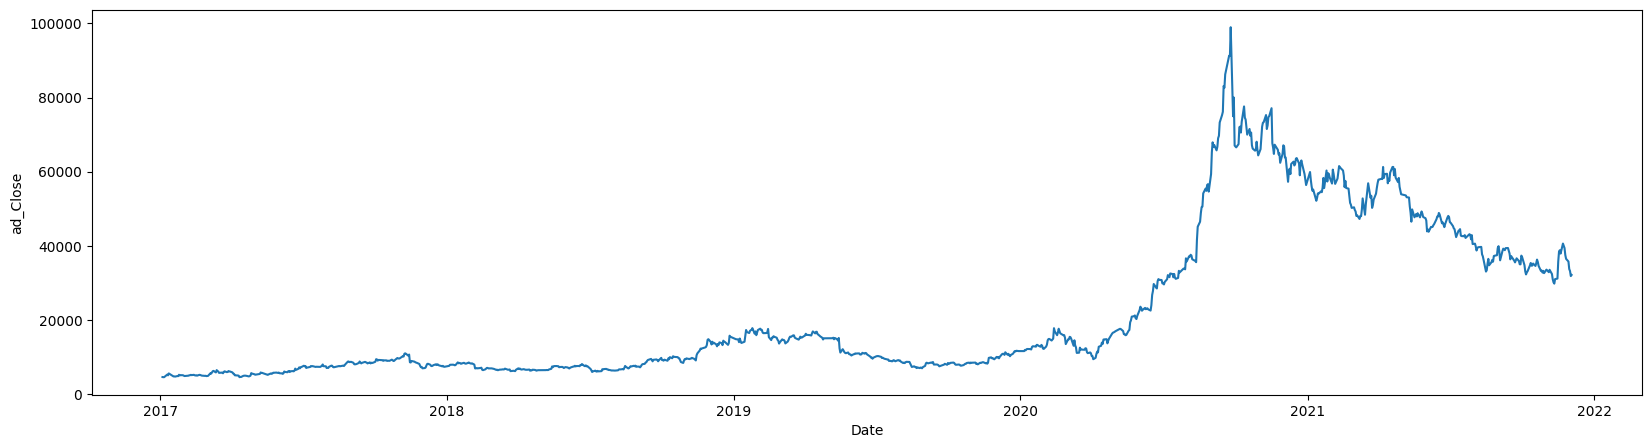

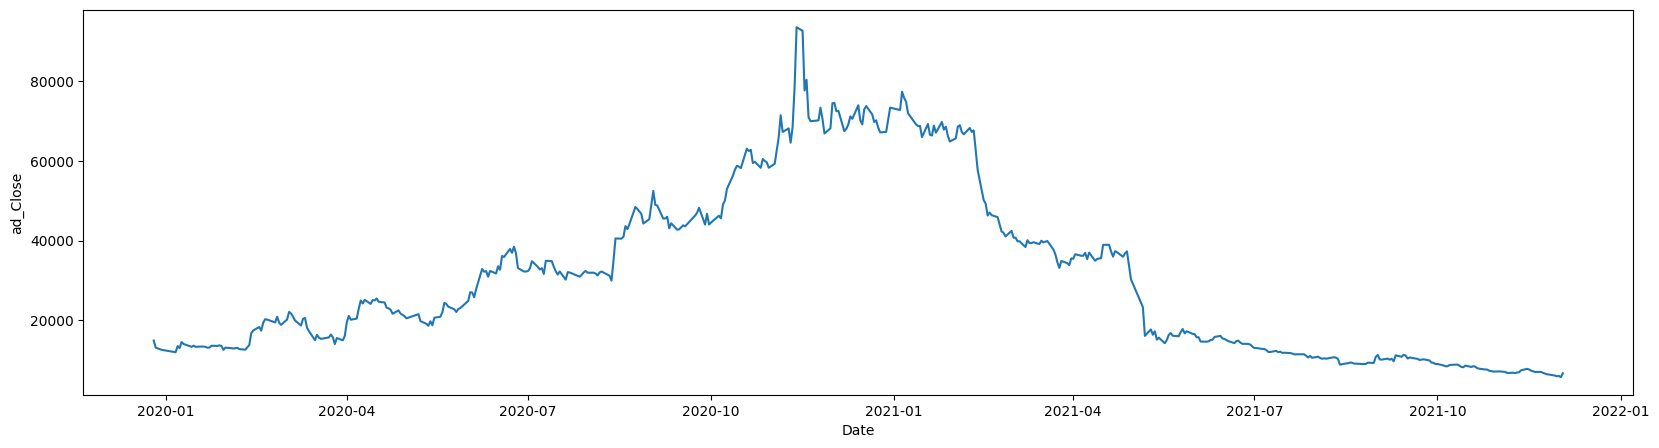

In [128]:
codes = [6861, 6920, 9983, 3962, 4488]
for cod in codes:
    df_code = df_security_code(adjusted_data, cod)
    plt.figure(figsize = (20,5))
    sns.lineplot(data=df_code, x ='Date', y ='ad_Close')

<AxesSubplot:xlabel='ad_Close', ylabel='Count'>

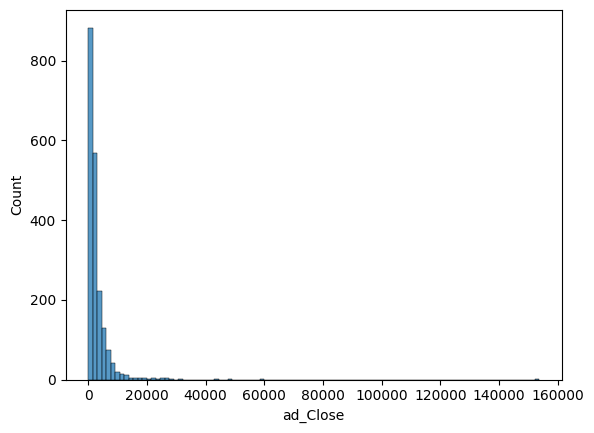

In [129]:
stock_group = adjusted_data.groupby('SecuritiesCode').mean()
sns.histplot(stock_group.ad_Close, bins=100)

- 100 günstigste

<AxesSubplot:xlabel='ad_Close', ylabel='Count'>

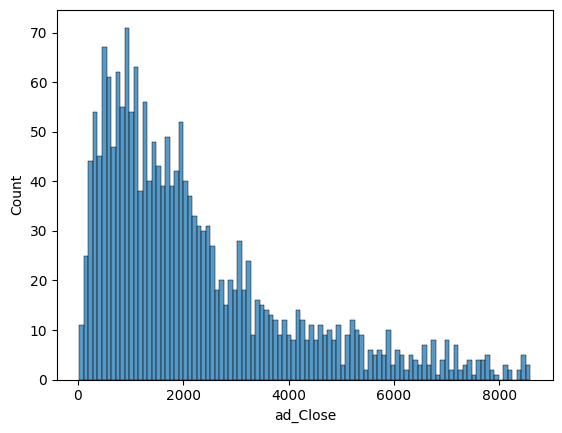

In [130]:
sns.histplot(stock_group.sort_values('ad_Close', ascending=False).ad_Close[100:], bins=100) 

- 100 teuerste


<AxesSubplot:xlabel='ad_Close', ylabel='Count'>

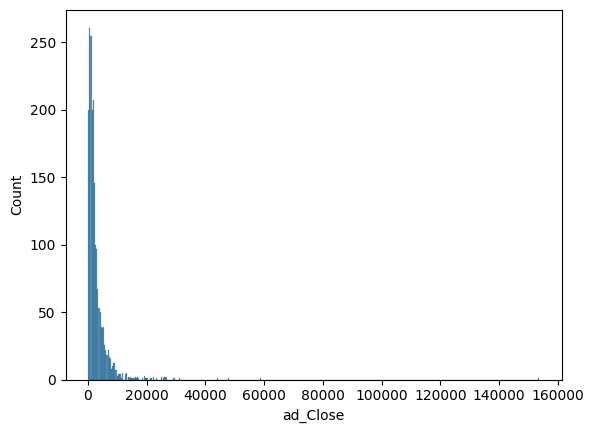

In [131]:
sns.histplot(stock_group.sort_values('ad_Close', ascending=True).ad_Close[10:]) 

In [132]:
stock_group.sort_values('ad_Close', ascending=True).tail(10)

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target
SecuritiesCode,,,,,,,,,,,,,,,
6194,4017.318068,4124.281432,3927.944213,4026.045795,1.027788e+05,0.998475,0.000000,0.000000,0.001978,26144.069109,26805.688593,25553.651124,26191.651124,1.385332e+04,0.002060
3349,20869.991674,21092.264779,20634.779351,20870.549542,1.209743e+05,0.999584,41.000000,0.000000,0.000595,26279.983347,26561.806828,25979.192340,26280.857619,9.490761e+04,0.000593
6920,7807.383014,7963.265612,7655.202331,7823.091590,1.290258e+06,0.999168,22.777778,0.000000,0.003795,26491.987510,27027.447960,25965.534555,26543.509575,4.058057e+05,0.003791
3540,5323.071503,5453.879793,5193.655959,5315.830052,4.115374e+04,0.999334,6.273333,0.822795,0.002070,26615.357513,27269.398964,25968.279793,26579.150259,8.230749e+03,0.002108
4880,13969.238281,14425.839844,13560.253906,13964.589844,9.683521e+04,0.997406,0.000000,0.000000,0.005452,29145.371094,29992.792969,28349.824219,29136.933594,6.595030e+04,0.005498
4488,31126.815287,32125.053079,30135.392781,31071.762208,1.315607e+05,1.000000,0.000000,0.000000,0.000120,31126.815287,32125.053079,30135.392781,31071.762208,1.315607e+05,-0.000218
7974,44022.139883,44506.981682,43521.444629,44025.911740,1.743796e+06,1.000000,434.000000,0.000000,0.000827,44022.139883,44506.981682,43521.444629,44025.911740,1.743796e+06,0.000836
6273,47859.275604,48377.169026,47328.205662,47851.494588,2.428007e+05,1.000000,140.000000,0.000000,0.001004,47859.275604,48377.169026,47328.205662,47851.494588,2.428007e+05,0.001005
9983,58652.031640,59266.269775,58014.238135,58637.601998,7.198596e+05,1.000000,217.500000,0.000000,0.000575,58652.031640,59266.269775,58014.238135,58637.601998,7.198596e+05,0.000554


In [133]:
def plot_stock(df, Code):
    df = df.query('SecuritiesCode==@Code')
    plt.figure(figsize=(20,5))
    sns.lineplot(data=df, y='Target', x='Date')
    sns.lineplot(data=df, y='ad_Target', x='Date', color = 'red')
    ax2 = plt.twinx()
    sns.lineplot(data=df, y='Close', x='Date')



## 5. Close, Open, High and Low price lag 1


In [134]:
df.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close', 'ad_Volume',
       'ad_Target'],
      dtype='object')

In [135]:


features = ['ad_Close', 'ad_Open', 'ad_High' , 'ad_Low', 'ad_Volume']
new_features = [x + "_lag1" for x in features]

feat_data = pd.DataFrame(columns = adjusted_data.columns)

def feature_lag(df, features, lag=1):
    for feat in features:
        name = feat + "_lag" +str(lag)
        df[name] = df[str(feat)].shift(lag)
        #new_features.append(name)
    return df


df = adjusted_data.query('SecuritiesCode ==@i')
df = feature_lag(df, features)



In [136]:
df[new_features + features].head()

,ad_Close_lag1,ad_Open_lag1,ad_High_lag1,ad_Low_lag1,ad_Volume_lag1,ad_Close,ad_Open,ad_High,ad_Low,ad_Volume
1311,NaN,NaN,NaN,NaN,NaN,31.0,31.0,32.0,31.0,641400.0
3176,31.0,31.0,32.0,31.0,641400.0,32.0,32.0,32.0,30.0,2621800.0
5041,32.0,32.0,32.0,30.0,2621800.0,31.0,32.0,32.0,30.0,2339800.0
6906,31.0,32.0,32.0,30.0,2339800.0,31.0,32.0,32.0,30.0,1690200.0
8771,31.0,32.0,32.0,30.0,1690200.0,31.0,31.0,32.0,31.0,426900.0


## 3. RSI

In [137]:
def rsi (df_serie,periods = 14, ema = True): 
    """Relative Strength Index
        RSI = 100–(100/1 + RS) ; RS = Av Gain / Av loss
    Args:
        df_serie (_type_): series of ad_Close
        periods (int, optional): 5,7,9,14,21,30 Defaults to 14.
        ema (bool, optional): _description_. Defaults to True.

    Returns:
        pd.Series: _description_
    """
        
    close_delta = df_serie.diff() # .dropna()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema == True: # exponential moving average
        ma_up = up.ewm(com= periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        
    else: # using moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.ewm(window = periods, adjust=False).mean()
        
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1+rs))

    return rsi

In [138]:
from functions import df_security_code

df = df_security_code(adjusted_data,8194 )
df['RSI'] = rsi(df['ad_Close'])

<Figure size 2000x500 with 0 Axes>

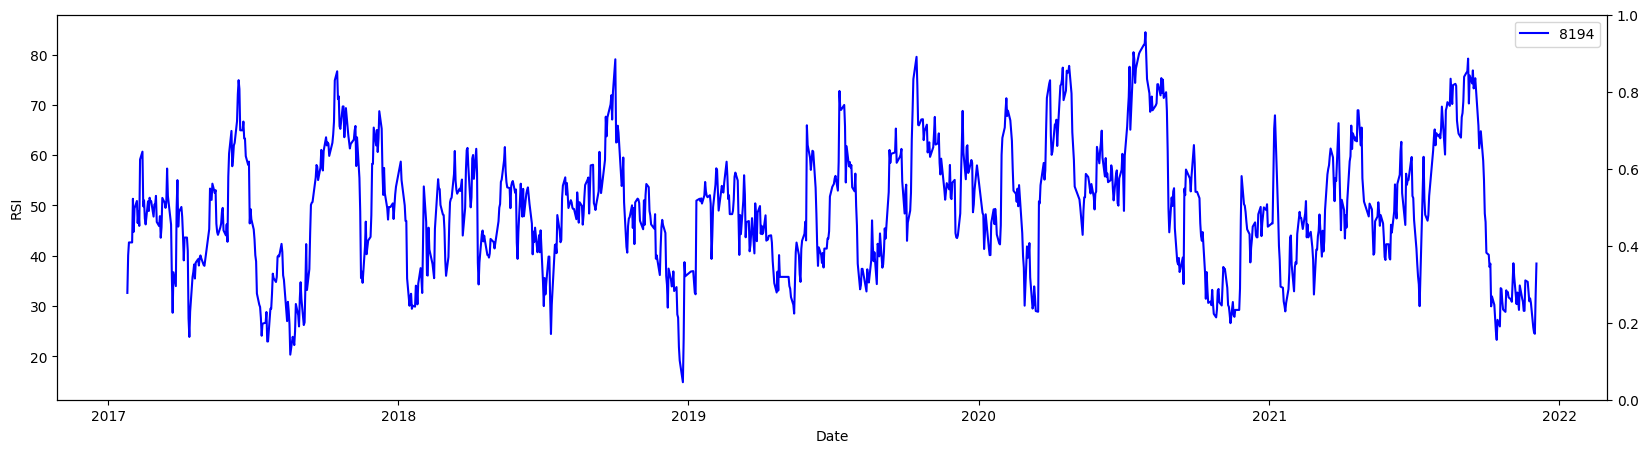

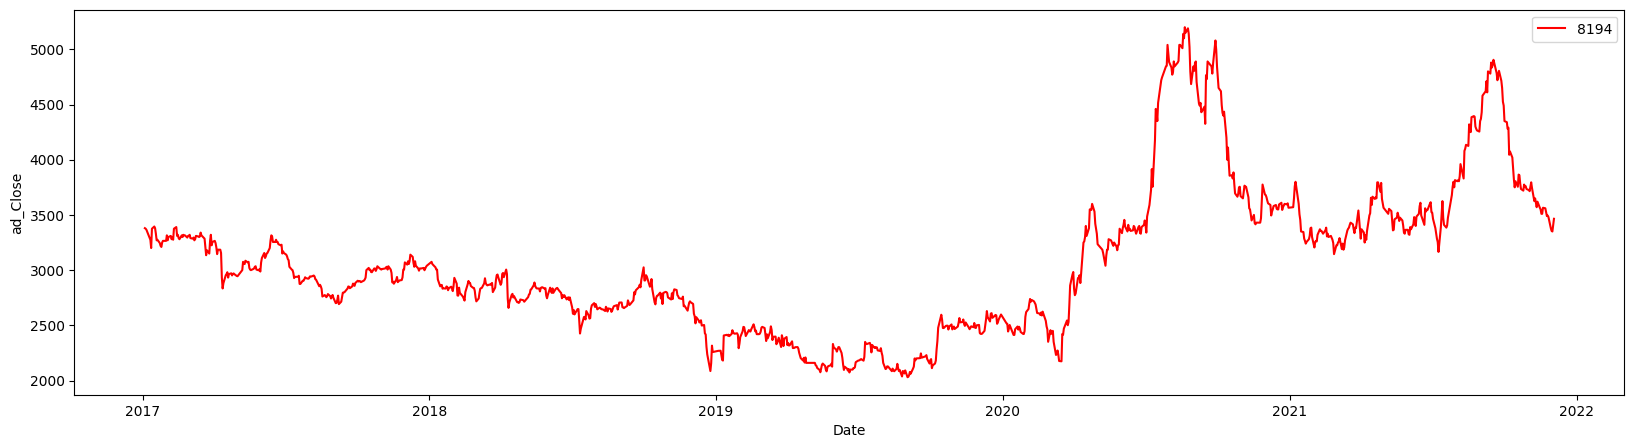

In [139]:
from functions import plot_stock

plt.figure(figsize=(20,5))
plot_stock(df, 8194 ,'RSI')
ax2 = plt.twinx()
plot_stock(df, 8194 ,'ad_Close', color='red')

## 4. Return

In [140]:
df['Return'] = df['ad_Close'].pct_change()
# adjusted_data['Return_m'] = adjusted_data['ad_Close'].resample('M').ffill().pct_change()


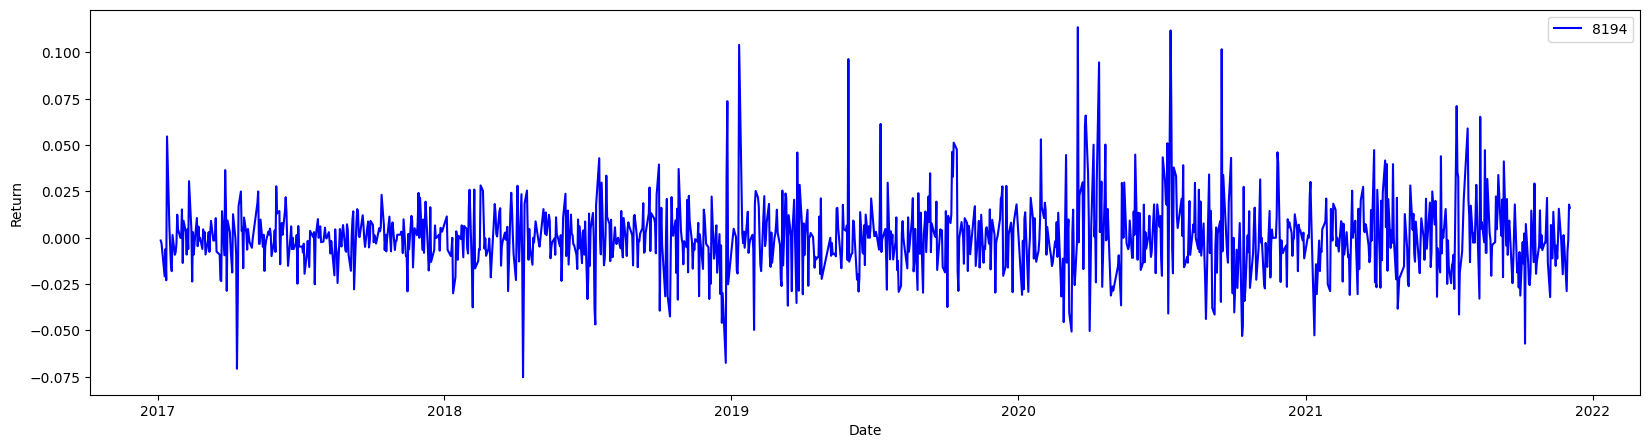

In [141]:
plot_stock(df, 8194, 'Return')

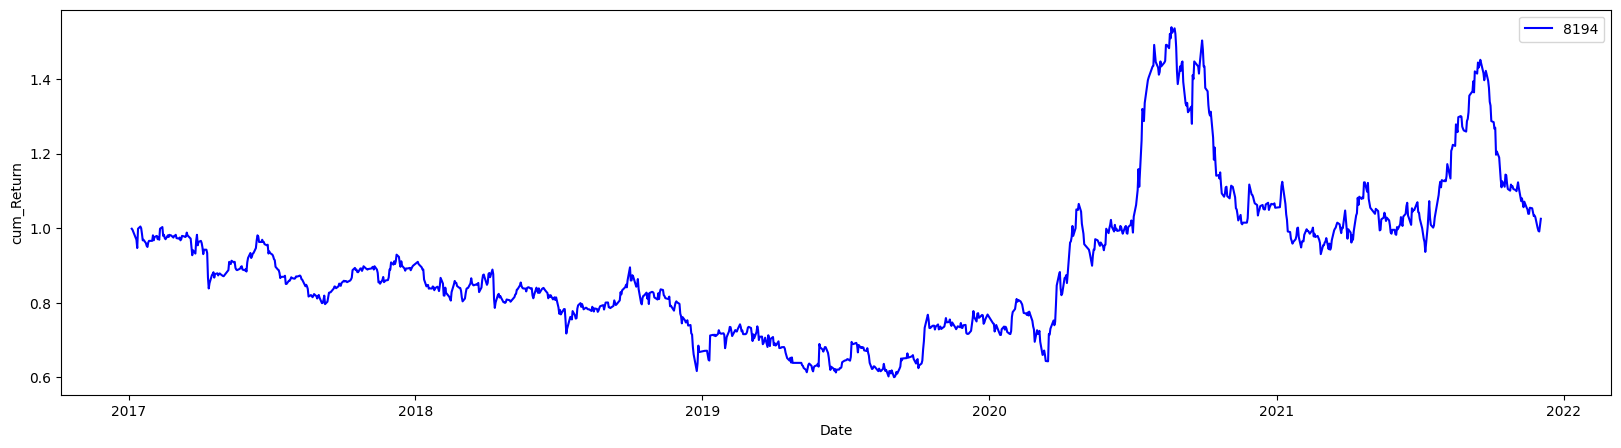

In [142]:
# cumulative
df['cum_Return'] = (df['Return'] + 1).cumprod()
plot_stock(df, 8194, 'cum_Return')

## 5. Simple moving average





In [143]:
# ussualy period 10 or 5
# setting for all prices



features = ['ad_Close', 'ad_Open', 'ad_High' , 'ad_Low', 'ad_Volume']
new_features = [x + "_sma10" for x in features]

feat_data = pd.DataFrame(columns = adjusted_data.columns)

def SMA(df, features, period=10):
    for feat in features:
        name = feat + "_sma" + str(period)
        df[name] = df[feat].rolling(window=period).mean()  # only for close or for all values?
        #new_features.append(name)
    return df


df = adjusted_data.query('SecuritiesCode == 8194')
df = SMA(df, features)

In [144]:
df[features +  new_features].head(20)

,ad_Close,ad_Open,ad_High,ad_Low,ad_Volume,ad_Close_sma10,ad_Open_sma10,ad_High_sma10,ad_Low_sma10,ad_Volume_sma10
1483,3380.0,3325.0,3390.0,3300.0,36100.0,NaN,NaN,NaN,NaN,NaN
3348,3375.0,3395.0,3420.0,3360.0,19400.0,NaN,NaN,NaN,NaN,NaN
5213,3365.0,3365.0,3385.0,3335.0,23000.0,NaN,NaN,NaN,NaN,NaN
7078,3295.0,3350.0,3360.0,3290.0,42400.0,NaN,NaN,NaN,NaN,NaN
8943,3275.0,3330.0,3330.0,3260.0,20200.0,NaN,NaN,NaN,NaN,NaN
10808,3200.0,3275.0,3290.0,3175.0,36600.0,NaN,NaN,NaN,NaN,NaN
12673,3375.0,3200.0,3385.0,3200.0,66900.0,NaN,NaN,NaN,NaN,NaN
14538,3395.0,3370.0,3415.0,3360.0,55100.0,NaN,NaN,NaN,NaN,NaN
16403,3380.0,3395.0,3410.0,3365.0,26700.0,NaN,NaN,NaN,NaN,NaN
18268,3330.0,3375.0,3375.0,3310.0,25300.0,3337.0,3338.0,3376.0,3295.5,35170.0


## 6. MACD : The Moving Average Convergence Divergence 



In [145]:

def macd(df):
    ema26 = df['ad_Close'].ewm(span=26, adjust=False, min_periods=26).mean()
    ema12 = df['ad_Close'].ewm(span=12, adjust=False, min_periods=12).mean()

    macd = ema12 - ema26

    # Get the 9-Day EMA of the MACD for the Trigger line

    macd_ema9 = macd.ewm(span=9, adjust=False, min_periods=9).mean()

    # calculate the difference
    macd_diff = macd - macd_ema9

    df['macd'] = df.index.map(macd)
    df['macd_h'] = df.index.map(macd_diff)
    df['macd_s'] = df.index.map(macd_ema9)

    return df

In [146]:
df = adjusted_data.query('SecuritiesCode == 8194')
df = macd(df)

In [147]:
df.tail()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,Target,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target,macd,macd_h,macd_s
2324137,20211129_8194,2021-11-29,8194,3435.0,3440.0,3375.0,3380.0,87400,1.0,NaN,...,-0.001490,3435.0,3440.0,3375.0,3380.0,87400.0,-0.001490,-124.794777,3.694951,-128.489728
2326137,20211130_8194,2021-11-30,8194,3395.0,3460.0,3350.0,3355.0,118700,1.0,NaN,...,0.017910,3395.0,3460.0,3350.0,3355.0,118700.0,0.017910,-129.275207,-0.628383,-128.646824
2328137,20211201_8194,2021-12-01,8194,3355.0,3380.0,3305.0,3350.0,123400,1.0,NaN,...,0.016129,3355.0,3380.0,3305.0,3350.0,123400.0,0.016129,-131.711154,-2.451464,-129.259690
2330137,20211202_8194,2021-12-02,8194,3350.0,3435.0,3350.0,3410.0,85600,1.0,NaN,...,0.001443,3350.0,3435.0,3350.0,3410.0,85600.0,NaN,-127.332353,1.541870,-128.874222
2332137,20211203_8194,2021-12-03,8194,3415.0,3475.0,3360.0,3465.0,73600,1.0,NaN,...,0.007205,3415.0,3475.0,3360.0,3465.0,73600.0,NaN,-118.063123,8.648880,-126.712002


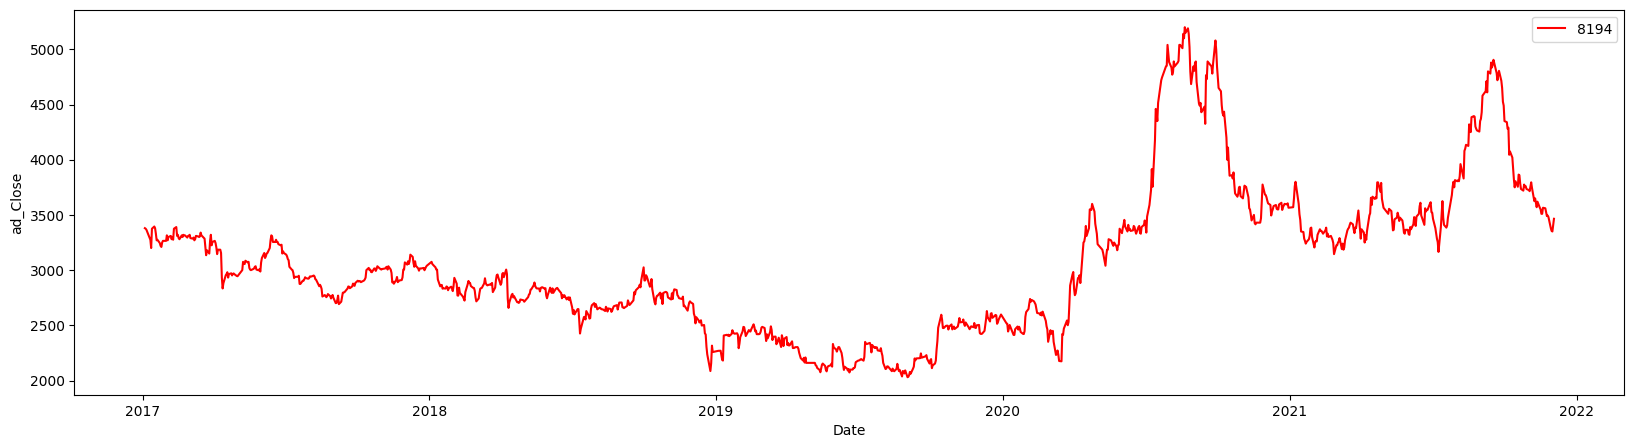

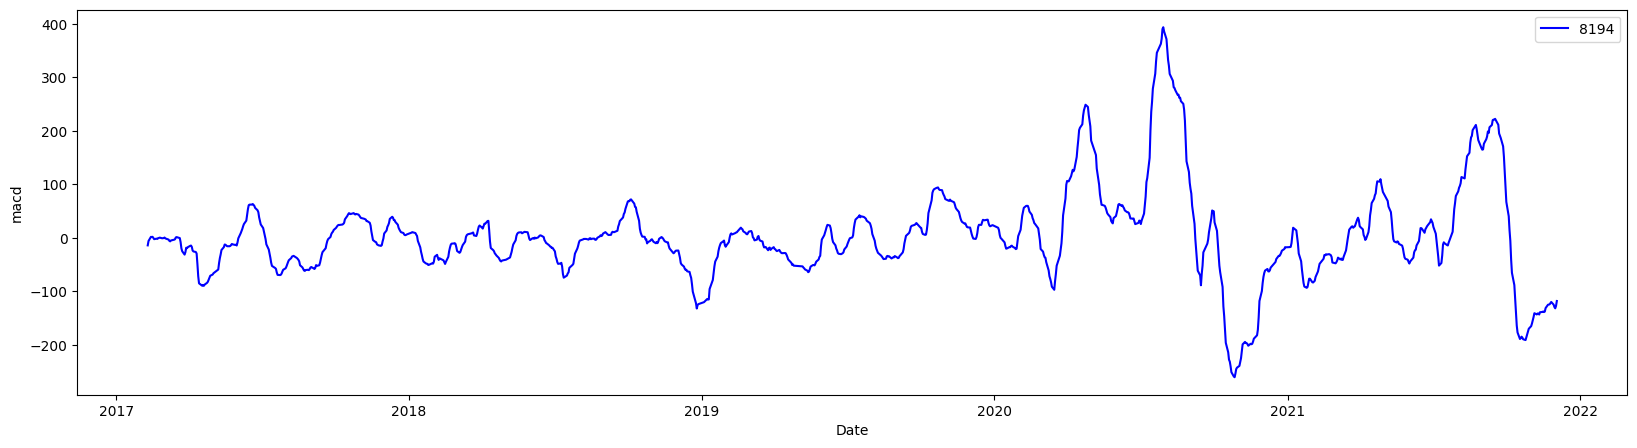

In [148]:

plot_stock(df, 8194, 'ad_Close', color='red')
plot_stock(df, 8194, 'macd')